# Rozdział 1: Wstęp i Konfiguracja

Technologia OCR (optyczne rozpoznawanie znaków) i inteligentne przetwarzanie dokumentów to dziś fundament cyfryzacji biznesu. Przeszliśmy długą drogę od prostych algorytmów do zaawansowanych modeli sztucznej inteligencji, które potrafią "rozumieć" obraz. Mimo tego postępu, wyciąganie tekstu z trudnych materiałów wciąż bywa wyzwaniem. Skomplikowane układy graficzne, nietypowe czcionki czy zdjęcia robione pod kątem potrafią zmylić nawet nowoczesne systemy. Dlatego, zamiast polegać na zapewnieniach producentów, kluczowe jest sprawdzenie w praktyce, które narzędzie najlepiej radzi sobie z konkretnymi problemami.

## Opis i cel projektu

Celem tego projektu jest praktyczne porównanie skuteczności popularnych bibliotek i usług chmurowych służących do ekstrakcji tekstu z obrazów oraz plików PDF. Badanie obejmuje szeroki przekrój rozwiązań: od darmowych narzędzi open-source (Tesseract, Docling), przez biblioteki do analizy struktury PDF (PyMuPDF, pdfplumber), aż po zaawansowane usługi komercyjne (Azure Document Intelligence).

Metodyka jest prosta i nastawiona na mierzalne wyniki. Działanie każdego z narzędzi porównuję z ręcznie przygotowanym wzorcem idealnego tekstu (tzw. Ground Truth). Wykorzystując algorytmy dopasowania rozmytego (fuzzy matching), oceniam procentową dokładność każdego rozwiązania. Testy przeprowadzam na zróżnicowanych danych – od tekstów z ksiązek i standardowych faktur po skomplikowane wizualnie ulotki. Pozwala zweryfikować, jak algorytmy radzą sobie nie tylko z czystym tekstem, ale też z trudną perspektywą i bogatą grafiką.

Ideą tego projektu było sprawdzenie, jak poszczególne narzędzia radzą sobie w najprostszym możliwym scenariuszu – czyli "prosto z pudełka", bez skomplikowanego dostrajania. Oczywistym jest, że gdybyśmy napisali dedykowane skrypty czyszczące tekst pod konkretny dokument, wyniki (szczególnie tych prostszych bibliotek) poszybowałyby w górę. To jednak pułapka: wymagałoby to nakładu pracy przy każdym nowym wzorze faktury czy ulotki. W firmach, gdzie codziennie przemiałowi ulegają tysiące identycznych dokumentów, takie "szycie na miarę" ma sens. Tutaj jednak chciałem pokazać surową wydajność: wrzucamy różnorodne pliki PDF i sprawdzamy, która biblioteka najinteligentniej poradzi sobie z nimi samodzielnie, bez naszej pomocy.

## Biblioteki

### Azure Document Inteligence

In [1]:
from azure.ai.documentintelligence import DocumentIntelligenceClient # Biblioteka od Azure do pdf - płatna, potęzna, analiza plików w chmurze z AI
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence.models import AnalyzeResult

Rozwiązanie klasy enterprise od Microsoftu. To potężna usługa chmurowa, która wykorzystuje zaawansowane modele AI wytrenowane na milionach dokumentów. Radzi sobie z pismem ręcznym, skomplikowanymi tabelami i fakturami, których inne narzędzia nie potrafią "ugryźć". Jakość jest topowa, ale wiąże się to z kosztami subskrypcji i koniecznością przesyłania danych do chmury. W skrócie: "Waga ciężka" do zadań specjalnych. Płacisz za najwyższą jakość i brak problemów z konfiguracją. 

W moim przypadku musiałem skonfigurować konto Azure i stworzyć tam zasób w postaci usługi "Document Inteligence", a następnie wygenerować kody API i podłączyć je w pythonie. Usługa jest bezpłatna do iluś tam wezwań

### PyMuPDF (fitz)

In [2]:
import fitz  #  Biblioteka do pdf PyMuPDF - podstawowa i szybka, opiera się na kodzie źródłowym 

Demon prędkości. To biblioteka, która technicznie nie jest OCR-em (choć ma takie funkcje), lecz narzędziem do "dobierania się" do wnętrza plików PDF. Jeśli dokument ma warstwę tekstową (nie jest tylko zdjęciem), PyMuPDF wyciągnie ją w ułamku sekundy. Jest niezastąpiony przy wstępnej filtracji i analizie dokumentów cyfrowych.

W skrócie: Najszybszy sposób na wyciągnięcie tekstu, o ile plik PDF nie jest samym skanem.

### pdfplumber

In [3]:
import pdfplumber #Biblioteka do pdf PDFplumber - równiez opiera sie na kodzie

Narzędzie dla precyzyjnych analityków. Działa wolniej niż PyMuPDF, ale oferuje znacznie większą kontrolę nad tym, jak wyciągamy dane. Jest bezkonkurencyjny, gdy trzeba "naprawić" tabelkę, która w PDF-ie się rozjechała, albo wyciągnąć tekst z konkretnego fragmentu strony co do piksela.

W skrócie: Narzędzie chirurgiczne – wolniejsze, ale idealne do precyzyjnej ekstrakcji danych, zwłaszcza z tabel.

### Docling

In [4]:
import docling # Biblioteka do pdf Docling - od IBM, oparta na AI oraz OCR, darmowa
from docling.document_converter import DocumentConverter 

Wschodząca gwiazda w świecie przetwarzania dokumentów, stworzona z myślą o erze sztucznej inteligencji. Docling nie tylko "czyta" literki, ale stara się zrozumieć strukturę całego dokumentu – wie, co jest nagłówkiem, co tabelą, a co przypisem. Jego supermocą jest konwersja dokumentów bezpośrednio do formatu Markdown, co czyni go idealnym narzędziem do przygotowywania danych dla modeli językowych (LLM).

W skrócie: Inteligentne narzędzie, które widzi strukturę dokumentu, a nie tylko ciąg znaków.

### Pozostałe uzyte biblioteki

In [36]:
from rapidfuzz import fuzz #Biblioteka do porownywania ze soba dwoch teksów
import time
import pandas as pd
import os
import re
from dotenv import load_dotenv
#biblioteka do wczytania kluczy API do Azure. Klucze pozostawilem ukryte ze wzgledu na prywatnosc
import configparser
config = configparser.ConfigParser()
config.read('client.ini')
AZURE_KEY = config["DocumentAI"]['api_key']
AZURE_ENDPOINT = config["DocumentAI"]['endpoint']



### Wczytanie plików tekstowych z zapisanym tekstem do porównania:

In [6]:
f = open('data/compare_docs/ground_truth_1.txt')
ground_truth_simple_1 = f.read()
f.close()

f = open('data/compare_docs/ground_truth_2.txt')
ground_truth_simple_2 = f.read()
f.close()

f = open('data/compare_docs/ground_truth_4.txt')
ground_truth_simple_4 = f.read()
f.close()

f = open('data/compare_docs/ground_truth_3.txt')
ground_truth_simple_3 = f.read()
f.close()

# Rozdział 2: Ekstrakcja tekstu ciągłego (E-book/Raport)

Pierwszy etap badań obejmuje analizę dokumentów typu born-digital, czyli plików PDF posiadających wbudowaną warstwę tekstową. Ze względu na dostępność struktury wewnętrznej dokumentu, jest to kategoria teoretycznie najmniej wymagająca dla algorytmów ekstrakcji. Ewaluacja jakościowa opiera się na metryce fuzz.ratio, weryfikującej stopień podobieństwa ciągów znaków. Zestaw testowy składa się z dwóch trzystronicowych dokumentów: publikacji anglojęzycznej o heterogenicznej strukturze (zawierającej elementy graficzne, wykresy oraz zróżnicowane wcięcia akapitowe) oraz publikacji polskojęzycznej o zmiennym formatowaniu. Celem tego eksperymentu jest weryfikacja bazowej skuteczności bibliotek w przetwarzaniu standardowego tekstu cyfrowego.

Poniżej zaprezentowano przykładową stronę pochodzącą z publikacji Introduction to Statistical Learning (ISLP). Materiał ten charakteryzuje się złożoną strukturą typograficzną, obejmującą nie tylko standardowy blok tekstu, ale również elementy graficzne (wykresy statystyczne), towarzyszące im podpisy oraz notację matematyczną.

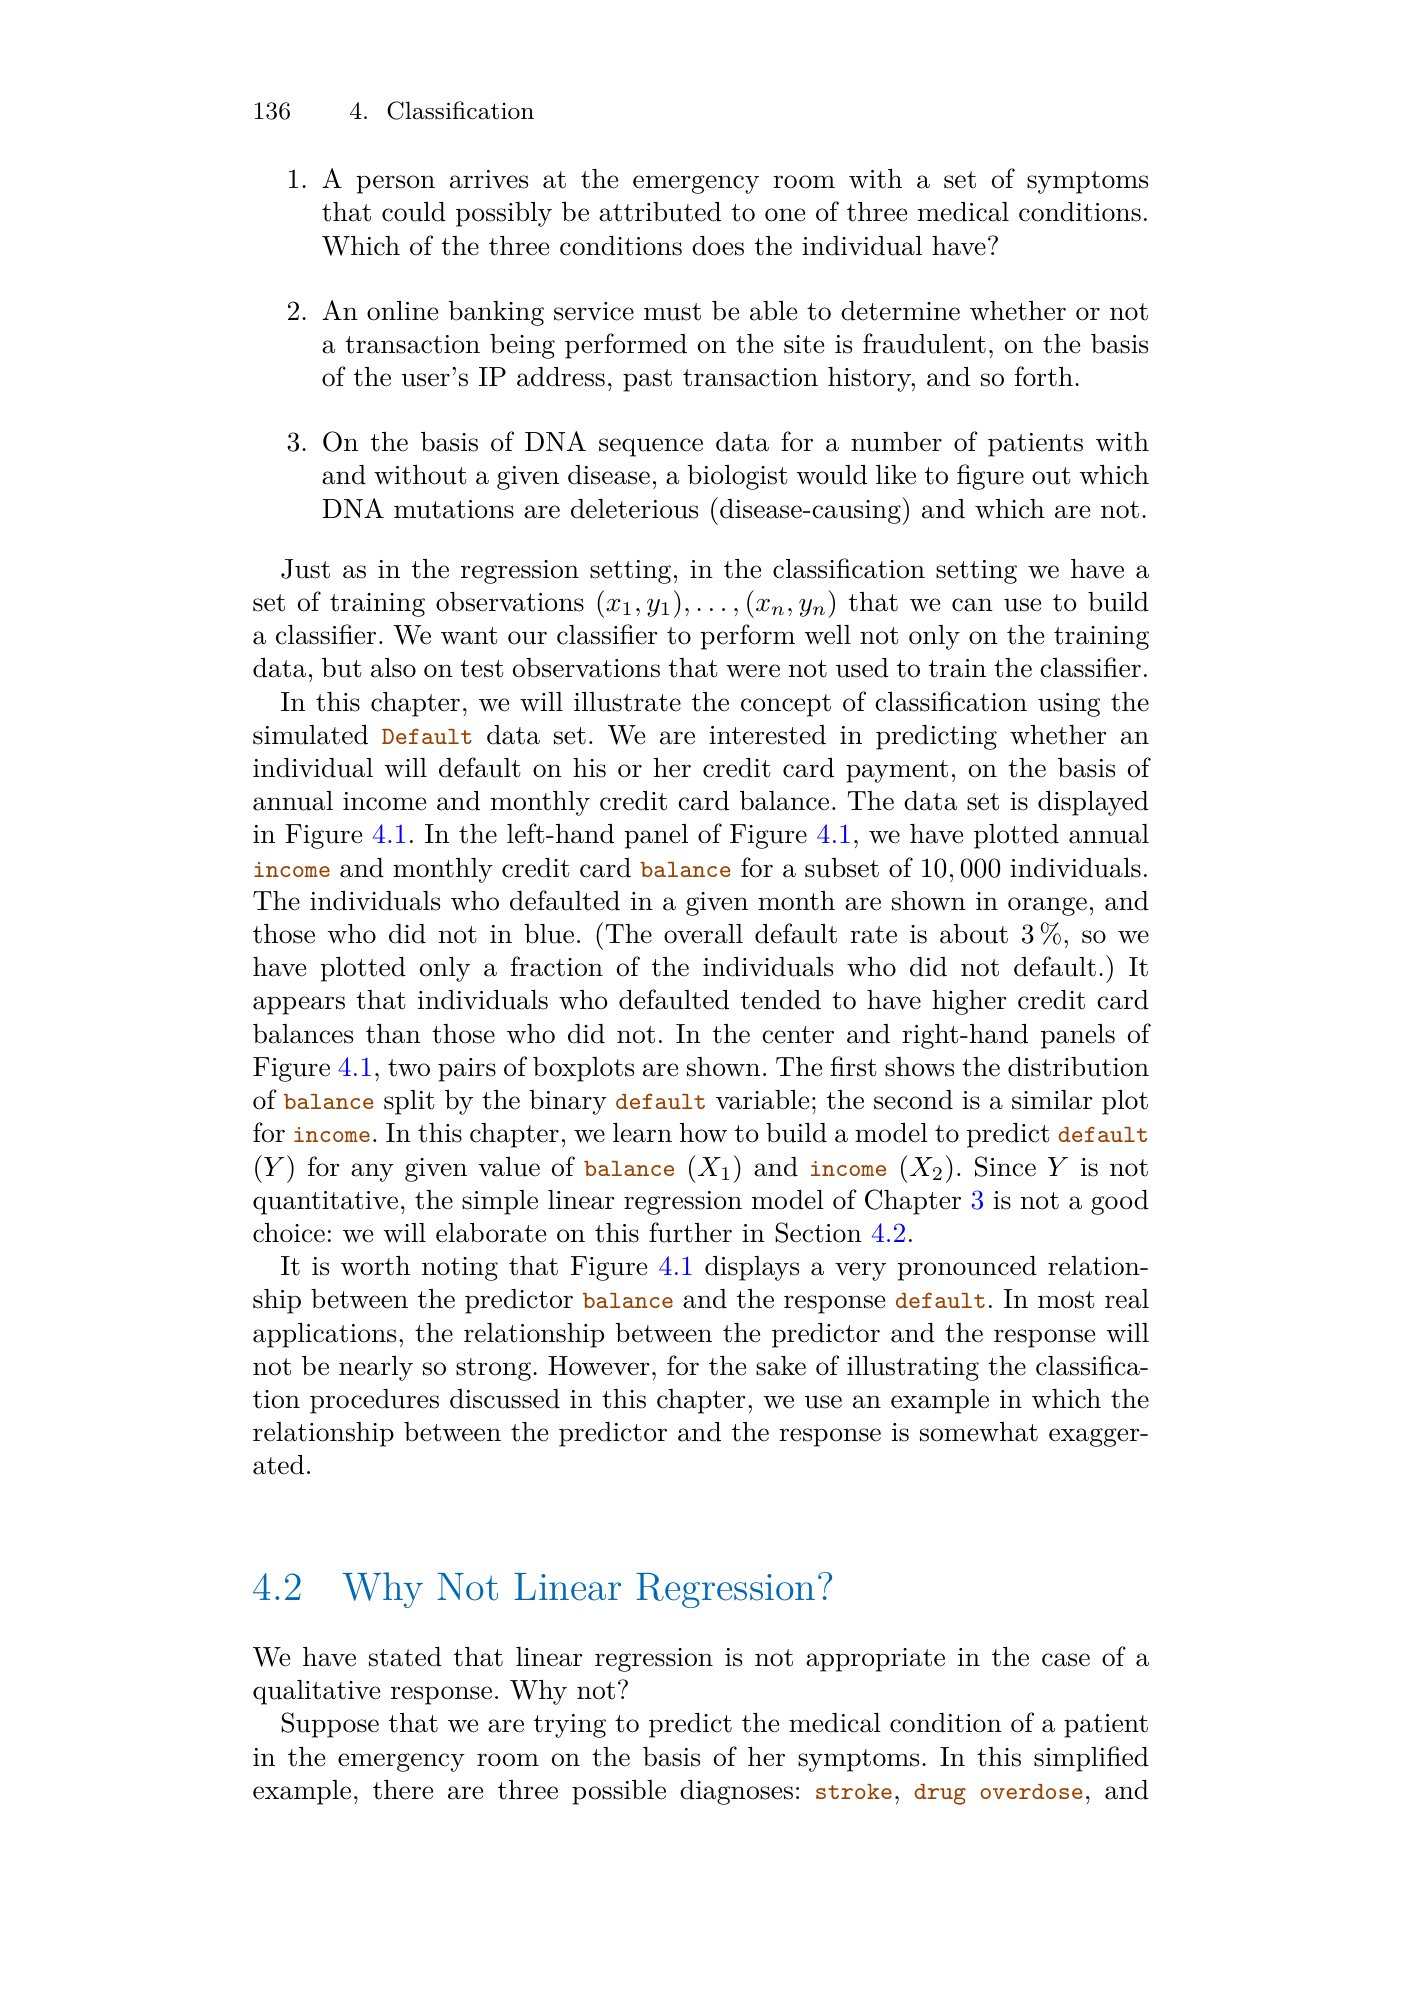

In [15]:
from pdf2image import convert_from_path
from IPython.display import display


pdf_path = "data/texts/ISLP_website-145-147.pdf"

images = convert_from_path(pdf_path, first_page=1, last_page=3)

display(images[0])

Kolejnym plikiem testowym jest fragment mojej własnej pracy licencjackiej pod tytułem: ***„Porównanie skuteczności algorytmów uczenia maszynowego i metod ekonometrycznych w modelowaniu cen samochodów używanych na rynku wtórnym”.*** Wybrałem ten dokument, aby sprawdzić, jak biblioteki poradzą sobie z typowym polskim tekstem akademickim i jego standardowym formatowaniem.

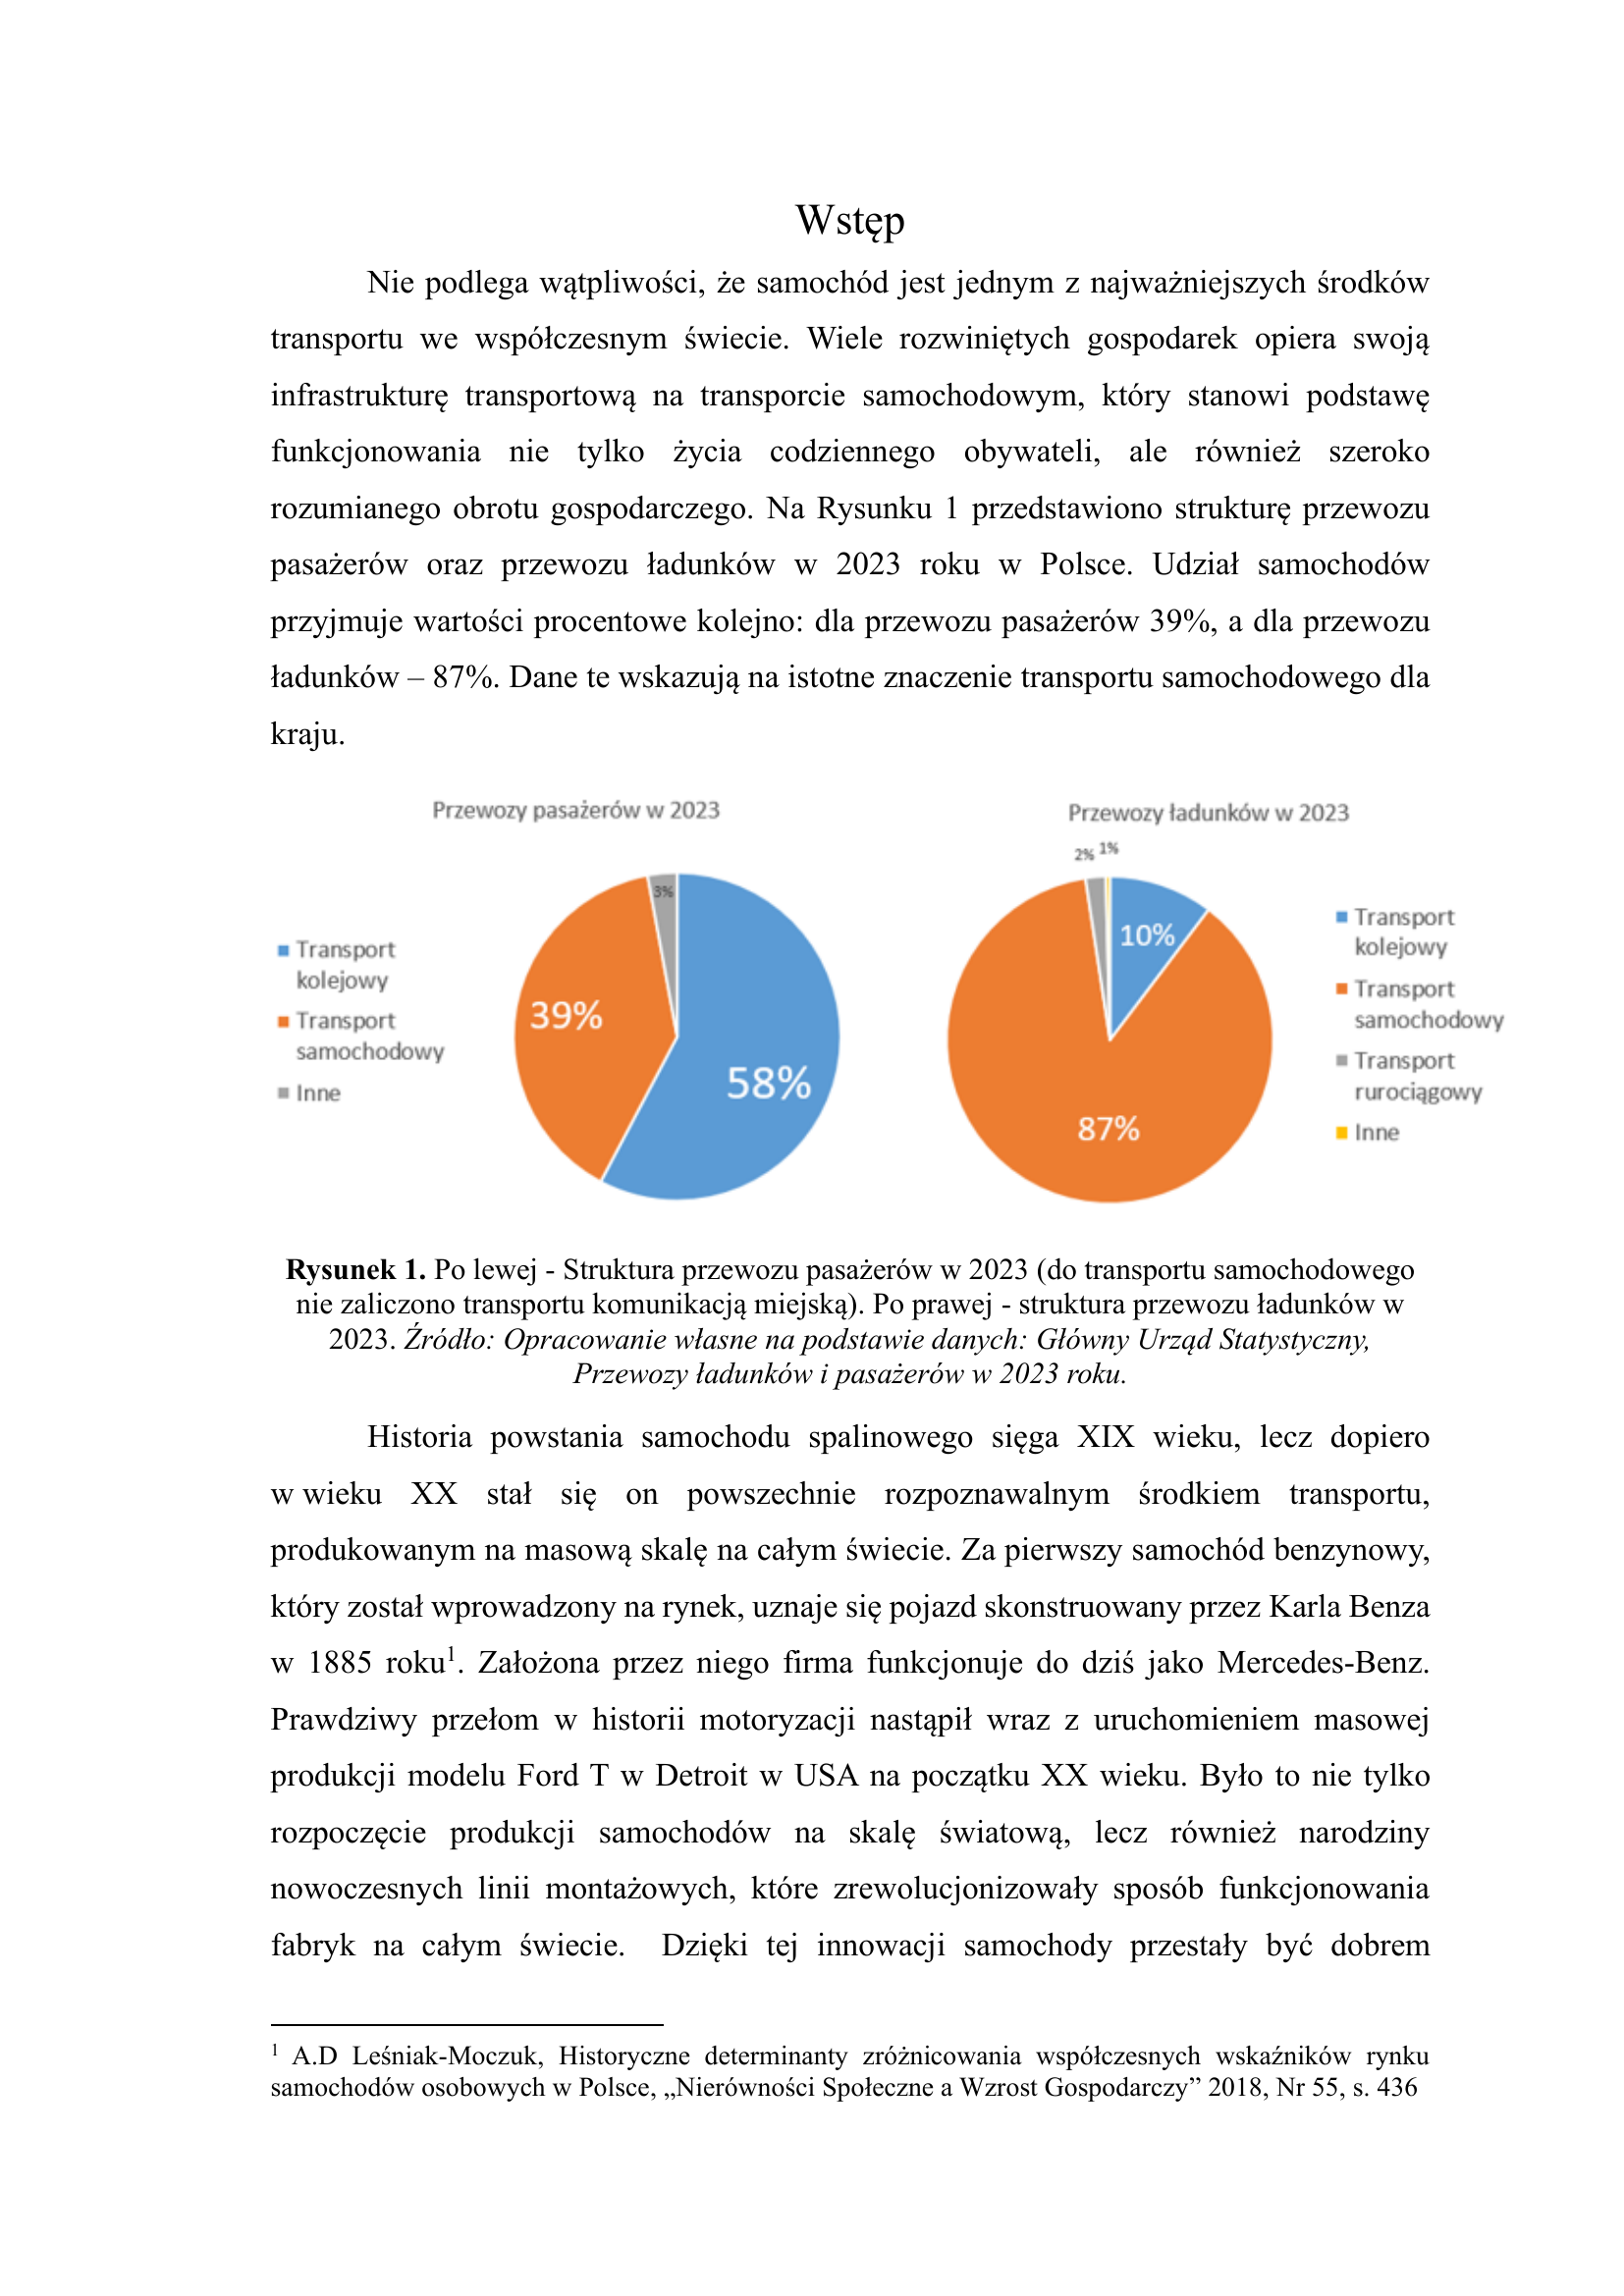

In [ ]:
pdf_path2 = "data/texts/03250103859-4-7.pdf"

images = convert_from_path(pdf_path2, first_page=1, last_page=3)

display(images[0])

## 2.1 Biblioteka PyMuPDF

### 2.1.1 Pordęcznik Akademicki po Angielsku

**Optymalizacja ekstrakcji dla biblioteki PyMuPDF**

W przypadku dokumentów o złożonym układzie (np. dwukolumnowy tekst naukowy, wykresy), domyślna metoda `get_text()` zwraca tekst w kolejności strumienia danych, co często prowadzi do wymieszania treści z obu kolumn. Aby uzyskać miarodajny wynik porównywalny z narzędziami AI (Docling/Azure), zastosowałem kilka transformacji i filtrów logicznych ("Pre-processing").

**Zastosowane usprawnienia w kodzie:**

1.  **Analiza układu (Layout Analysis):**
    * Użycie metody `page.get_text("blocks", sort=True)`. Flaga `sort=True` wymusza na bibliotece próbę odtworzenia naturalnej kolejności czytania, co jest kluczowe przy układzie wielokolumnowym.

2.  **Filtrowanie geometryczne (Header/Footer Removal):**
    * Zdefiniowano marginesy odcięcia (górne i dolne 5% strony). Bloki tekstu, których współrzędne `y0` i `y1` wskazują na nagłówek lub stopkę (np. numery stron, tytuły rozdziałów), są dynamicznie pomijane.

3.  **Eliminacja szumu (Noise Reduction):**
    * **Ignorowanie grafik:** Bloki oznaczone przez PyMuPDF jako obrazy (`block_type != 0`) są odrzucane, aby uniknąć błędów kodowania tekstu ukrytego pod obrazkami.
    * **Filtrowanie artefaktów:** Krótkie ciągi liczbowe (np. samotne numery stron, które uciekły filtrowi marginesów) są usuwane.

4.  **Normalizacja tekstu (Post-processing):**
    * **De-hyphenation:** Sklejanie wyrazów podzielonych myślnikiem na końcach linii (np. zamiana `classifi-\ncation` na `classification`). Jest to niezbędne do poprawnego obliczenia metryki podobieństwa.
    * **Whitespace Normalization:** Usunięcie wielokrotnych spacji i znaków nowej linii, sprowadzając tekst do jednolitego ciągu.

In [27]:
#funkcja do czyszczenia tekstu
def clean_pymupdf_text(text):
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie PyMuPDF...")
start = time.perf_counter()

try:
    doc = fitz.open(pdf_path)
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 1500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)



Testowanie PyMuPDF...
Time: 0.0645 s
Accuracy Score: 93.18%
------------------------------
PREVIEW (First 1500 chars):
1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth. 3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not. Just as in the regression setting, in the classification setting we have a set of training observations (x1, y1), . . . , (xn, yn) that we can use to build a classifier. We want our classifier to perform well not only on the training data, but also on test observations that wer

Kawałek tekstu ze wzorem matematycznym:

In [28]:
text_pymu_cleaned[3500:4000]

'We could consider encoding these values as a quantitative response variable, Y , as follows: \uf8f1 \uf8f4 \uf8f2 Y = \uf8f4 \uf8f3 1 if stroke; 2 if drug overdose; 3 if epileptic seizure. Using this coding, least squares could be used to fit a linear regression model to predict Y on the basis of a set of predictors X1, . . . , Xp. Unfortunately, this coding implies an ordering on the outcomes, putting drug overdose in between stroke and epileptic seizure, and insisting that the difference between stroke and drug overdo'

**Wyniki**

PyMuPDF poradził sobie z tym zadaniem naprawdę solidnie. Większość tekstu została odczytana poprawnie, a biblioteka podjęła nawet skuteczną próbę zamiany zapisu matematycznego na zwykły tekst. Wprawdzie przy skomplikowanych równaniach wynik nie był w 100% idealny, ale wciąż pozostawał zrozumiały. Głównym brakiem jest tutaj ignorowanie struktury dokumentu – biblioteka nie potrafiła oddzielić nagłówków od reszty treści, co jest standardem w nowocześniejszych narzędziach opartych na AI.

### 2.1.2 Praca naukowa po polsku

In [29]:

def clean_pymupdf_text(text):
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie PyMuPDF")
start = time.perf_counter()

try:
    doc = fitz.open(pdf_path2)
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_1.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 1500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)

Testowanie PyMuPDF
Time: 0.0607 s
Accuracy Score: 95.97%
------------------------------
PREVIEW (First 1500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków – 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunikacją miejską). Po prawej - struktura przewozu ładunków w 2023. Źródło: Opracowanie własne na podstawie danych: Główny Urząd St

**Wyniki**

Tak samo jak w przypadku książki po angielsku, biblioteka poradziła sobie tutaj naprawdę solidnie. Program skutecznie wyciągnął z pliku sam tekst, automatycznie ignorując przy tym wszystkie obrazki i grafiki.

## 2.2 PDFplumber

### 2.2.1 Pordęcznik Akademicki po Angielsku

#### Optymalizacja ekstrakcji dla biblioteki PDFPlumber 

PDFPlumber jest narzędziem bardziej zaawansowanym niż PyMuPDF w kontekście analizy układu (lepiej radzi sobie z tabelami), ale jest znacznie wolniejszy. Aby poprawić jakość wyniku i uniknąć "szumu" z marginesów, zastosowano filtrowanie przestrzenne.

**Zastosowane usprawnienia w kodzie:**

1.  **Geometryczne przycinanie strony:**
    * Zamiast przetwarzać całą stronę, zastosowano metodę `.crop()`, definiując obszar zainteresowania.
    * Odrzucono górne i dolne 5% wysokości strony. Pozwala to na fizyczne usunięcie numerów stron, stopek i tytułów rozdziałów jeszcze przed rozpoczęciem analizy tekstu. Dzięki temu algorytm ekstrakcji nie "widzi" tych elementów i nie miesza ich z treścią akapitów.

2.  **Inteligentna ekstrakcja:**
    * Wykorzystano domyślną heurystykę `.extract_text()`, która w PDFPlumberze dobrze radzi sobie z wykrywaniem odstępów między wyrazami

3.  **Czyszczenie post-ekstrakcyjne:**
    * **Whitespace Normalization:** PDFPlumber ma tendencję do generowania wielu spacji w celu odwzorowania układu wizualnego. Zredukowano je do pojedynczych spacji, aby uzyskać ciągły tekst.
    * **De-hyphenation:** Usunięto podziały wyrazów (myślniki na końcu linii), aby umożliwić poprawne porównanie z wzorcem.

In [21]:

def clean_plumber_text(text):
    if not text: return ""
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie pdfplumber")
start = time.perf_counter()

text_plumber = ""
t_plumber = 0
score_plumber = 0

try:
    with pdfplumber.open(pdf_path) as doc:
        text_parts = []
        for page in doc.pages:
        
            width = page.width
            height = page.height
            
            crop_box = (0, height * 0.05, width, height * 0.95)
            
            try:
                cropped_page = page.crop(crop_box)
                
                txt = cropped_page.extract_text()
                
                if txt:
                    text_parts.append(txt)
            except ValueError:
                txt = page.extract_text()
                if txt:
                    text_parts.append(txt)

    t_plumber = time.perf_counter() - start
    
    raw_text = "\n".join(text_parts)
    text_plumber_cleaned = clean_plumber_text(raw_text)
    
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_plumber = fuzz.ratio(text_plumber_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"pdfplumber Error: {e}")
    text_plumber_cleaned = ""
    score_plumber = 0.0

# --- Wyświetlanie wyników ---
print(f"Time: {t_plumber:.4f} s")
print(f"Accuracy Score: {score_plumber:.2f}%")

print("-" * 30)
print("PREVIEW (First 1500 chars):")
print(text_plumber_cleaned[:1500] + "...")
print("-" * 30)

Testowanie pdfplumber
Time: 1.1486 s
Accuracy Score: 91.60%
------------------------------
PREVIEW (First 1500 chars):
136 4. Classification 1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user’s IP address, past transaction history, and so forth. 3. On the basis of DNA sequence data for a number of patients with andwithoutagivendisease,abiologistwouldliketofigureoutwhich DNA mutations are deleterious (disease-causing) and which are not. Just as in the regression setting, in the classification setting we have a set of training observations (x ,y ),...,(x ,y ) that we can use to build 1 1 n n a classifier. We want our classifier to perform well not only on the training data,butalsoontestobservationstha

Kawałek tekstu ze wzorem:

In [24]:
print(text_plumber_cleaned[3500:4000])

considerencodingthesevaluesasaquantitative response variable, Y, as follows: 1 if stroke; Y =  2 if drug overdose; 3 if epileptic seizure. Usingthiscoding,leastsqu arescouldbeusedtofitalinearregressionmodel to predict Y on the basis of a set of predictors X ,...,X . Unfortunately, 1 p this coding implies an ordering on the outcomes, putting drug overdose in between stroke and epileptic seizure, and insisting that the difference between stroke and drug overdose is the same as the difference 


PDFplumber poradził sobie poprawnie, ale wypadł wyraźnie słabiej niż jego konkurent. Sam wynik punktowy (Accuracy) może być tutaj mylący - dopiero przy wczytaniu się w tekst widać, że biblioteka ma problemy. Znacznie częściej gubi spacje, sklejając wyrazy, i wtrąca w treść dziwne, przypadkowe znaki. Gorzej poradziła sobie również z wzorami matematycznymi, zamieniając je w zestaw nieczytelnych symboli, podczas gdy PyMuPDF przynajmniej próbował zachować logiczny układ nawiasów.

### 2.2.2 Artykuł naukowy po polsku

In [12]:

def clean_plumber_text(text):
    if not text: return ""
    text = text.replace("-\n", "")
    text = " ".join(text.split())
    return text

results = []
print("Testowanie pdfplumber")
start = time.perf_counter()

text_plumber = ""
t_plumber = 0
score_plumber = 0

try:
    with pdfplumber.open(pdf_path2) as doc:
        text_parts = []
        for page in doc.pages:
        
            width = page.width
            height = page.height
            
            crop_box = (0, height * 0.05, width, height * 0.95)
            
            try:
                cropped_page = page.crop(crop_box)
                
                txt = cropped_page.extract_text()
                
                if txt:
                    text_parts.append(txt)
            except ValueError:
                txt = page.extract_text()
                if txt:
                    text_parts.append(txt)

    t_plumber = time.perf_counter() - start
    
    raw_text = "\n".join(text_parts)
    text_plumber_cleaned = clean_plumber_text(raw_text)
    
    ground_truth_cleaned = " ".join(ground_truth_simple_1.split())
    score_plumber = fuzz.ratio(text_plumber_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"pdfplumber Error: {e}")
    text_plumber_cleaned = ""
    score_plumber = 0.0

print(f"Time: {t_plumber:.4f} s")
print(f"Accuracy Score: {score_plumber:.2f}%")

print("-" * 30)
print("PREVIEW (First 1500 chars):")
print(text_plumber_cleaned[:1500] + "...")
print("-" * 30)

Testowanie pdfplumber
Time: 0.3970 s
Accuracy Score: 95.98%
------------------------------
PREVIEW (First 1500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków – 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunikacją miejską). Po prawej - struktura przewozu ładunków w 2023. Źródło: Opracowanie własne na podstawie danych: Główny Urząd

**Wyniki**

Przy tekście polskim biblioteka ponownie spisała się bardzo dobrze, skutecznie czyszcząc wynik ze zbędnych numerów stron czy nagłówków rozdziałów. Dużym plusem jest fakt, że program nie próbował na siłę odczytywać danych bezpośrednio z wykresów, dzięki czemu uniknęliśmy bałaganu w wynikowym pliku tekstowym. Niestety, pojawił się też wyraźny minus: biblioteka nie rozpoznała podpisów pod grafikami i wplotła je w ciągły tekst. To typowy błąd narzędzi tej klasy – dopiero rozwiązania oparte na AI potrafią skutecznie oddzielić opis ilustracji od reszty akapitu.

## 2.3 Docling

Testując bibliotekę Docling, opartą na AI i OCR, celowo nie stosowałem żadnych dodatkowych funkcji czyszczących tekst. Wyszedłem z założenia, że tak zaawansowane technologicznie narzędzia, powinny poradzić sobie z analizowanym materiałem samodzielnie. Chciałem sprawdzić, czy obietnice o inteligencji tego rozwiązania pokrywają się z rzeczywistością bez potrzeby ręcznego dopieszczania wyników.

### 2.3.1 Pordęcznik Akademicki po Angielsku

In [31]:
results = []
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None

try:
    converter = DocumentConverter()
    res = converter.convert(pdf_path)
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    t_docling = time.perf_counter() - start
    score_docling = fuzz.ratio(text_docling.strip(), ground_truth_simple_2.strip()) if text_docling.strip() else 0.0
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    score_docling = 0.0

print(f"Time: {t_docling:.4f} s")
print(f"Accuracy Score: {score_docling:.2f}%")

print("-" * 30)
print("PREVIEW (First 2000 chars):")
print(text_docling[:2000] + "...")
print("-" * 30)

Time: 3.3313 s
Accuracy Score: 74.53%
------------------------------
PREVIEW (First 2000 chars):
1. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have?
2. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user's IP address, past transaction history, and so forth.
3. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.

Just as in the regression setting, in the classification setting we have a set of training observations ( x 1 , y 1 ) , . . . , ( x n , y n ) that we can use to build a classifier. We want our classifier to perform well not only on the training data, but also on test observations that were not used

Kawałek tekstu z wzorem matematycznym:

In [32]:
print(text_docling[3000:4000])

FIGURE 4.1. The Default data set. Left: The annual incomes and monthly credit card balances of a number of individuals. The individuals who defaulted on their credit card payments are shown in orange, and those who did not are shown in blue. Center: Boxplots of balance as a function of default status. Right: Boxplots of income as a function of default status.

<!-- image -->

epileptic seizure . We could consider encoding these values as a quantitative response variable, Y , as follows:

<!-- formula-not-decoded -->

Using this coding, least squares could be used to fit a linear regression model to predict Y on the basis of a set of predictors X 1 , . . . , X p . Unfortunately, this coding implies an ordering on the outcomes, putting drug overdose in between stroke and epileptic seizure , and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure . In practice there is no particular reason that this needs

**Wynik**

Ciekawostką jest tutaj wyraźny spadek wyniku punktowego – o około 15–20% w porównaniu do prostszych konkurentów. Nie oznacza to jednak, że biblioteka działa gorzej. Niższy wynik wynika z faktu, że narzędzie to inteligentnie przetwarza dokument, konwertując go na format Markdown, zamiast kopiować każdy znak. To duży plus -  program bezbłędnie rozpoznał, co jest nagłówkiem czy podtytułem, a w miejsce grafik wstawił odpowiednie znaczniki. Z matematyką poszło nieco gorzej – biblioteka zauważyła wzór, ale nie potrafiła go odczytać, oznaczając go jako formula not decoded. Jednak za te zaawansowane funkcje płacimy czasem. Narzędzie działało 3–4 razy wolniej od prostszych bibliotek, co przy przetwarzaniu tysięcy plików może być kluczowym problemem. Mimo to, jeśli zależy nam na jakości samego tekstu i strukturze, a nie na surowym wyniku procentowym, biblioteka poradziła sobie świetnie.

### 2.3.2 Praca naukowa po polsku

In [34]:
results = []
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None

try:
    converter = DocumentConverter()
    res = converter.convert(pdf_path2)
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    t_docling = time.perf_counter() - start
    score_docling = fuzz.ratio(text_docling.strip(), ground_truth_simple_1.strip()) if text_docling.strip() else 0.0
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    score_docling = 0.0

print(f"Time: {t_docling:.4f} s")
print(f"Accuracy Score: {score_docling:.2f}%")

print("-" * 30)
print("PREVIEW (First 2000 chars):")
print(text_docling[:2000] + "...")
print("-" * 30)

Time: 5.9920 s
Accuracy Score: 92.35%
------------------------------
PREVIEW (First 2000 chars):
• Transport kolejowy

• Transport samochodowy

• Inne

Przewozy pasażerów w 2023

3%

Przewozy tadunków w 2023

2% 1%

10%

## Wstęp

• Transport kolejowy

• Transport

Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu  we  współczesnym  świecie.  Wiele  rozwiniętych  gospodarek  opiera  swoją infrastrukturę  transportową  na  transporcie  samochodowym,  który  stanowi  podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów  oraz  przewozu  ładunków  w  2023  roku  w  Polsce.  Udział  samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków - 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. Inne

Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transpor

**Wynik**

W tym przypadku Docling zaliczył dość niespodziewaną wpadkę, gdyż wyrwał legendę z wykresu i wstawił ją na sam początek dokumentu, co wprowadziło spory chaos. Poza tym jednym błędem biblioteka poradziła sobie solidnie, precyzyjnie wskazując lokalizację wykresów oraz poprawnie wykrywając nagłówki i miejsca występowania wzorów. Wyraźnym minusem jest jednak obsługa przypisów, których narzędzie nie rozpoznało jako odrębnych elementów i wplotło je w sam środek zdań głównego tekstu. Warto też pamiętać, że czas działania programu był ponownie znacząco dłuższy w porównaniu do prostszych, tradycyjnych bibliotek.

## 2.4 Azure Document Inteligence

### 2.4.1 Pordęcznik Akademicki po Angielsku

In [ ]:
def clean_markdown_text(text):
    if not text: return ""
    text = re.sub(r'(\*\*|__)(.*?)\1', r'\2', text) 
    text = re.sub(r'#+\s+', '', text) 
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text) 
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text) 
    text = text.replace('|', ' ').replace('---', '')
    # Normalizacja spacji
    text = " ".join(text.split())
    return text

def run_azure_book_test(pdf_path, ground_truth_text):
    print("Wysyłanie pliku do chmury.")
    
    start_time = time.perf_counter()
    extracted_text_cleaned = ""
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )
        
        with open(pdf_path, "rb") as f:
            # 1. Wymuszamy format Markdown dla zachowania kolejności czytania (szpalty!)
            poller = client.begin_analyze_document(
                "prebuilt-layout", 
                body=f,
                content_type="application/pdf",
                output_content_format="markdown" 
            )
        
        result = poller.result()
        
        # 2. Pobieramy całą treść (content), a nie tabele
        raw_text = result.content
        
        # 3. Czyścimy wynik
        extracted_text_cleaned = clean_markdown_text(raw_text)
        
        # Sukces
        duration = time.perf_counter() - start_time
        
        # 4. Obliczamy wynik (jeśli podano ground truth)
        score = 0.0
        if ground_truth_text:
            # Normalizujemy też ground truth dla pewności
            gt_cleaned = " ".join(ground_truth_text.split())
            score = fuzz.ratio(extracted_text_cleaned, gt_cleaned)
            
        return extracted_text_cleaned, duration, score

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")
        return "", time.perf_counter() - start_time, 0.0

text_azure, t_azure, score_azure = run_azure_book_test(pdf_path, ground_truth_simple_2)
print("\n" + "="*30)
print(f"Time: {t_azure:.4f} s")
print(f"Accuracy Score: {score_azure:.2f}%")
print("="*30)
print("PREVIEW (First 500 chars):")
print(text_azure[:1500] + "...")

--- ☁️ Azure AI (Book Mode): ISLP_website-145-147.pdf ---
(Wysyłanie pliku do chmury...)

Time: 8.2860 s
Accuracy Score: 68.53%
PREVIEW (First 500 chars):
<!-- PageNumber="136" --> <!-- PageHeader="4. Classification" --> 1\. A person arrives at the emergency room with a set of symptoms that could possibly be attributed to one of three medical conditions. Which of the three conditions does the individual have? 2\. An online banking service must be able to determine whether or not a transaction being performed on the site is fraudulent, on the basis of the user's IP address, past transaction history, and so forth. 3\. On the basis of DNA sequence data for a number of patients with and without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not. Just as in the regression setting, in the classification setting we have a set of training observations (x1,91), ... , (In, yn) that we can use to build a classifier. We wan

Kawałek tekstu ze wzorem matematycznym:

In [42]:
print(text_azure[3000:4000])

iagnoses: stroke, drug overdose, and <!-- PageBreak --> <!-- PageNumber="137" --> <!-- PageHeader="4.2 Why Not Linear Regression?" --> <figure> <figcaption>FIGURE 4.1. The Default data set. Left: The annual incomes and monthly credit card balances of a number of individuals. The individuals who defaulted on their credit card payments are shown in orange, and those who did not are shown in blue. Center: Boxplots of balance as a function of default status. Right: Boxplots of income as a function of default status.</figcaption> 2500 60000 00 00 2000 60000 Income 40000 Balance 1500 Income 40000 20000 1000 00 0 20000 500 0 0 0 0 500 1000 1500 2000 2500 No Yes No Yes Balance Default Default </figure> epileptic seizure. We could consider encoding these values as a quantita- tive response variable, Y, as follows: 1 if stroke; Y = \ 2 if drug overdose; 3 if epileptic seizure. Using this coding, least squares could be used to fit a linear regression model to predict Y on the basis of a set of pr

**Wyniki**

Wynik punktowy w tym przypadku jest mylący i nie powinien przesłaniać faktycznych możliwości narzędzia, które dodaje do rezultatu sporo własnych znaczników technicznych. Te dodatkowe informacje teoretycznie psują wynik porównania z oryginałem, ale w praktyce pokazują wyższość biblioteki Azure, która precyzyjnie rozpoznaje, co jest numerem strony, nagłówkiem, a nawet osią wykresu czy podpisem pod rysunkiem. Dzięki umieszczaniu tych elementów w odpowiednich kontenerach praca z tekstem staje się znacznie prostsza, ponieważ w łatwy sposób można zdecydować o zachowaniu lub usunięciu opisów grafik. Jeśli chodzi o samą jakość odczytu tekstu, nie można mieć żadnych zastrzeżeń, a i ze wzorami matematycznymi program poradził sobie całkiem sprawnie. Warto jednak zwrócić uwagę, że za tę precyzję płacimy czasem, gdyż analiza pliku trwała ponad osiem sekund, co jest dość znaczącym wynikiem.

### 2.4.2 Praca naukowa po polsku

In [44]:
text_azure, t_azure, score_azure = run_azure_book_test(pdf_path2, ground_truth_simple_1)
print("\n" + "="*30)
print(f"Time: {t_azure:.4f} s")
print(f"Accuracy Score: {score_azure:.2f}%")
print("="*30)
print("PREVIEW (First 500 chars):")
print(text_azure[:1500] + "...")

--- ☁️ Azure AI (Book Mode): 03250103859-4-7.pdf ---
(Wysyłanie pliku do chmury...)

Time: 7.2226 s
Accuracy Score: 63.59%
PREVIEW (First 500 chars):
Wstęp Nie podlega wątpliwości, że samochód jest jednym z najważniejszych środków transportu we współczesnym świecie. Wiele rozwiniętych gospodarek opiera swoją infrastrukturę transportową na transporcie samochodowym, który stanowi podstawę funkcjonowania nie tylko życia codziennego obywateli, ale również szeroko rozumianego obrotu gospodarczego. Na Rysunku 1 przedstawiono strukturę przewozu pasażerów oraz przewozu ładunków w 2023 roku w Polsce. Udział samochodów przyjmuje wartości procentowe kolejno: dla przewozu pasażerów 39%, a dla przewozu ładunków - 87%. Dane te wskazują na istotne znaczenie transportu samochodowego dla kraju. <figure> <figcaption>Rysunek 1. Po lewej - Struktura przewozu pasażerów w 2023 (do transportu samochodowego nie zaliczono transportu komunikacją miejską). Po prawej - struktura przewozu ładunków w</figcaption> P

Moment przejścia strony na kolejną, problem z przypisami:

In [54]:
text_azure[1900:2200]

'świecie. Dzięki tej innowacji samochody przestały być dobrem 1 A.D Leśniak-Moczuk, Historyczne determinanty zróżnicowania współczesnych wskaźników rynku samochodów osobowych w Polsce, „Nierówności Społeczne a Wzrost Gospodarczy” 2018, Nr 55, s. 436 <!-- PageBreak --> luksusowym dostępnym wyłącznie d'

**Wyniki**

Podobnie jak w poprzednich testach, biblioteka Azure Document Intelligence poradziła sobie z odczytaniem tekstu niemal bezbłędnie, choć przydarzyło się jej małe potknięcie przy wykresie, gdzie fragment opisu został błędnie potraktowany jako zwykła część akapitu. Niestety, biblioteka nie rozpoznała też przypisów dolnych, traktując je jak resztę treści. Mimo tych drobnych wpadek całość wygląda bardzo solidnie, ponieważ program precyzyjnie wskazał lokalizację nagłówków i wykresów oraz poprawnie oznaczył większość podpisów pod grafikami.

## 2.5 Podsumowanie czytania ksiązek

Dwie prostsze biblioteki, czyli PyMuPDF i PDFplumber, poradziły sobie z samym wyciąganiem tekstu całkiem nieźle, a gdyby poświęcić chwilę na napisanie dodatkowych funkcji czyszczących, wyniki mogłyby być naprawdę imponujące. Ich ogromną zaletą jest szybkość działania, co przy pracy z setkami plików może być decydującym czynnikiem. Z drugiej strony mamy narzędzia AI, takie jak Docling i Azure Document Intelligence, które wygrywają nie tyle samą jakością liter, co bogactwem dodatkowych funkcji. Możliwość eksportu do formatu Markdown, którą oferuje Docling, to świetna sprawa przy tworzeniu e-booków, gdzie automatyczne wykrywanie tytułów i podtytułów oszczędza mnóstwo pracy. Z kolei Azure okazał się najdokładniejszy z całej czwórki, świetnie radząc sobie z oddzielaniem opisów wykresów od głównej treści książki, choć trzeba pamiętać, że jest to rozwiązanie wolniejsze i płatne. Mimo tych wszystkich zalet sztucznej inteligencji, w kategorii zwykłych książek i prostego tekstu moim faworytem pozostaje PyMuPDF. Do tego typu zadań jest to narzędzie w zupełności wystarczające, które oferuje świetny kompromis między jakością a szybkością, bez niepotrzebnego komplikowania procesu.

# Rozdział 3: Ekstrakcja danych strukturalnych (Faktury/Tabele)

W tym segmencie chcialbym sprawdzic jak biblioteki radzą sobie z problemem faktur, ktore są złozonymi dokumentami. Posiadaja numer faktury, odbiorce, firme i najwazniejsze - rzeczy, ktore sa wystawione na fakturze. Czesto sa one podane w formie tabelki, choc nie zawsze. Przykladowy i testowany pdf faktury ukazuje ponizej:

TO PONIZEJ TO FAKTURA PROSTA I PRZYJEMNA

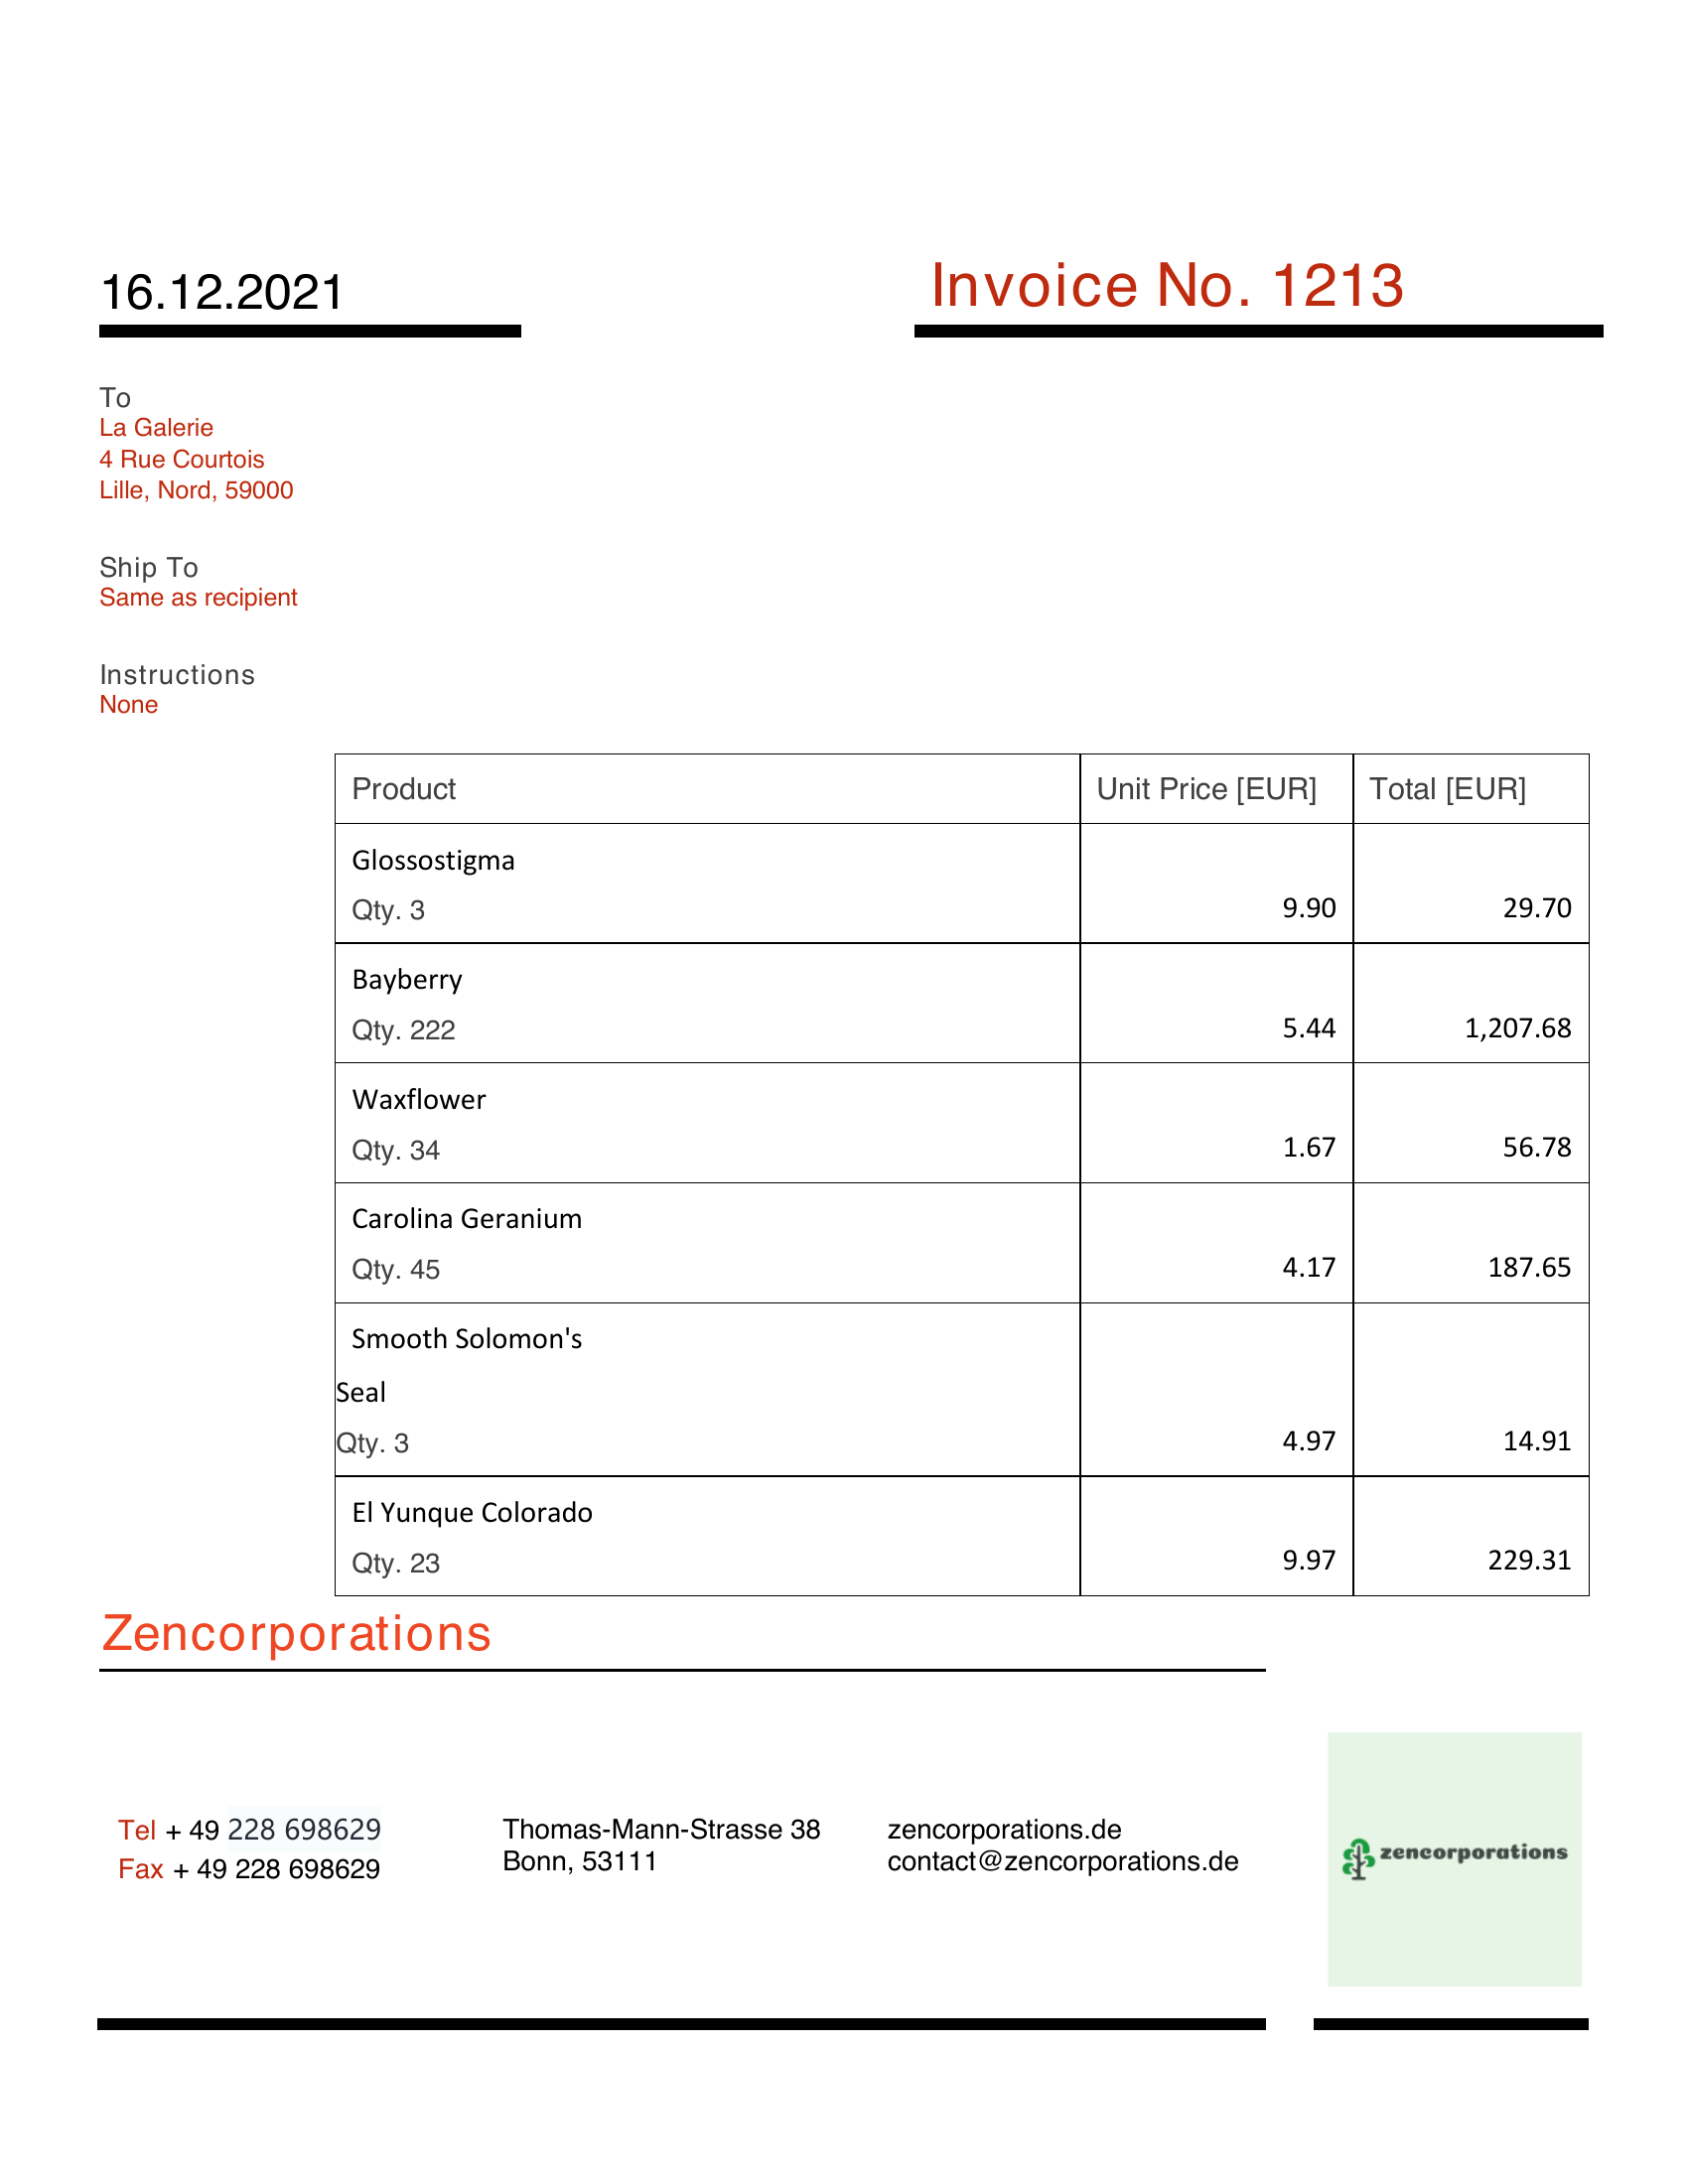

In [14]:
pdf_path_1 = "data/invoices/invoice-1-3.pdf"

images = convert_from_path(pdf_path_1, first_page=1, last_page=1)

display(images[0])

TO PONIZEJ TO FAKTURA CIEZKA I BEZ LINI

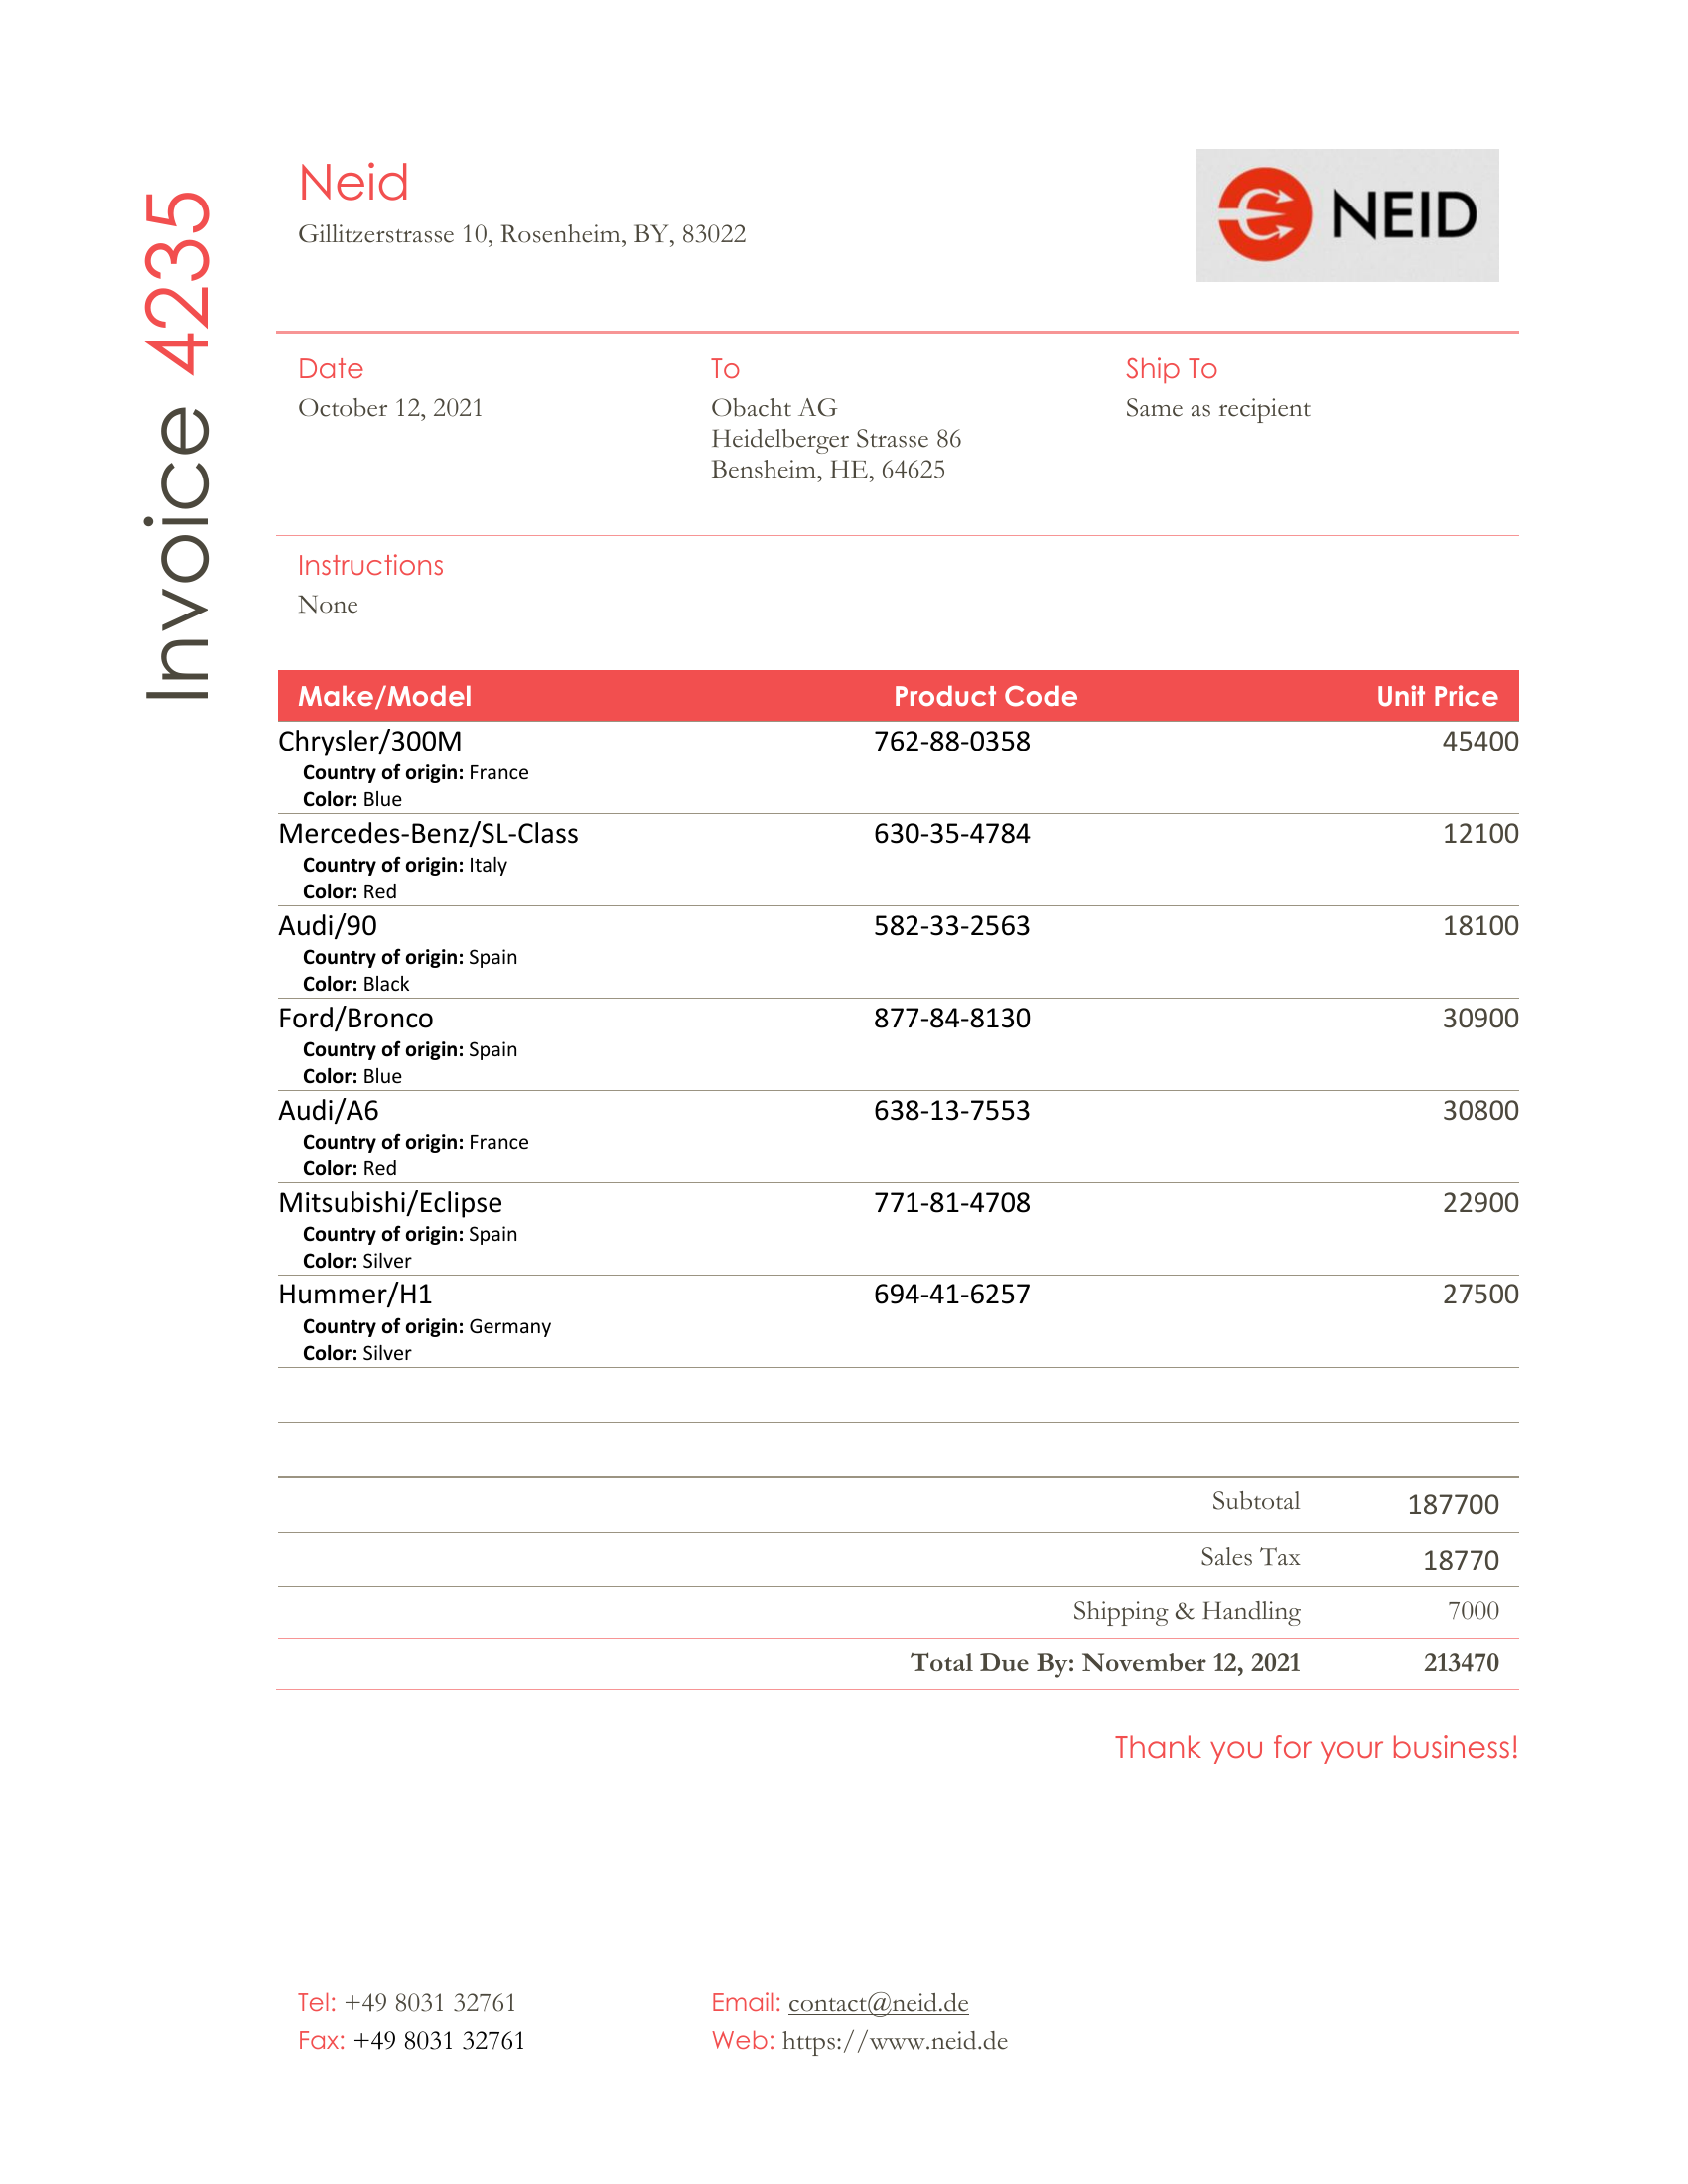

In [15]:
pdf_path = "data/invoices/invoice-3-0.pdf"

images = convert_from_path(pdf_path, first_page=1, last_page=1)

display(images[0])

## 3.1 PyMuPDF

Jako ze ciezko jest przetestowac skutecznosc bibliotek na fakturach, bo wymagaloby to bardzo duzej ilosci plikow z labelami to w tej pracy skupie sie tylko na tym, czy bibiolteka (bez tuningu) znalazla numer faktury, date faktury i najwazniejsze - tabelkę z pozycjami faktury.

### 3.1.1 Faktura prosta

In [16]:
# doc=fitz.open("data/invoices/invoice-1-3.pdf")
# page=doc[0]

# tabs = page.find_tables(strategy='lines')

# if tabs.tables:
#     for table in tabs.tables:
#         df=table.to_pandas()
#         display(df)


def extract_metadata_pymupdf(text):
    """
    Funkcja pomocnicza próbująca znaleźć dane za pomocą Regex (sztywne reguły).
    Działa tylko wtedy, gdy faktura pasuje do wzorca!
    """
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    nr_match = re.search(r"(?:Faktura|Nr|Numer|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
        
    
    return metadata


doc = fitz.open("data/invoices/invoice-1-3.pdf")
print(f"--- 📄 Analiza PyMuPDF dla pliku: 9.pdf ---")
for page in doc: 
    
    tabs = page.find_tables(strategy='lines') 

    if tabs.tables:
        for i, table in enumerate(tabs.tables):
            df = table.to_pandas()
            display(df)
    else:
        print("❌ Nie wykryto tabeli (metoda 'lines').")

    raw_text = page.get_text()

print("\n🔍 Wykryte Metadane (Regex):")
meta = extract_metadata_pymupdf(raw_text)

# Wyświetlamy wyniki w ładnej formie
for klucz, wartosc in meta.items():
    if wartosc:
        print(f"✅ {klucz}: {wartosc}")
    else:
        print(f"⚠️ {klucz}: Nie znaleziono (wymagany inny wzorzec Regex)")


--- 📄 Analiza PyMuPDF dla pliku: 9.pdf ---
Consider using the pymupdf_layout package for a greatly improved page layout analysis.


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                                Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30


🔍 Wykryte Metadane (Regex):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91


### 3.1.2 Faktura cięzka

In [17]:
doc = fitz.open("data/invoices/invoice-3-0.pdf")
for page in doc: 
    
    tabs = page.find_tables(strategy='lines') 

    if tabs.tables:
        for i, table in enumerate(tabs.tables):
            df = table.to_pandas()
            display(df)
    else:
        print("❌ Nie wykryto tabeli (metoda 'lines').")

    raw_text = page.get_text()

print("\n🔍 Wykryte Metadane (Regex):")
meta = extract_metadata_pymupdf(raw_text)

# Wyświetlamy wyniki w ładnej formie
for klucz, wartosc in meta.items():
    if wartosc:
        print(f"✅ {klucz}: {wartosc}")
    else:
        print(f"⚠️ {klucz}: Nie znaleziono (wymagany inny wzorzec Regex)")


Empty DataFrame
Columns: [Make/Model, Product Code, Unit Price]
Index: []


🔍 Wykryte Metadane (Regex):
✅ Numer faktury: e
⚠️ Data wystawienia: Nie znaleziono (wymagany inny wzorzec Regex)
⚠️ Suma (Brutto): Nie znaleziono (wymagany inny wzorzec Regex)


Powyzej ukazane sa wszystkie tabele, ktore udalo sie wyciagnac z faktury. Wynik nie jest zły - udało się znaleźć tabelę z numerem faktury i datą faktury. Niestety główna tabela z pozycjami faktury została co prawda wyciągnięta, ale nazwy kolumn znajdują się w wierszu pierwszym, a wartości w wierszu drugim. Gdyby się postarać, to za pomocą funkcji moznaby uzyskac ladna tabele.

## 3.2 PDFplumber

### 3.2.1 Faktura prosta

In [18]:
def extract_metadata_regex(text):
 
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    if not text:
        return metadata

    nr_match = re.search(r"(?:Faktura|Nr|Numer'|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
    
    return metadata



pdf_path = "data/invoices/invoice-1-3.pdf" # Twoja ścieżka
tables_all = []
metadata_found = {}

print(f"--- 🔧 Analiza PDFPlumber: {pdf_path} ---")

try:
    with pdfplumber.open(pdf_path) as pdf:
        # Zakładamy, że metadane są na 1. stronie
        first_page = pdf.pages[0]
        
        # A. WYCIĄGANIE TEKSTU DLA METADANYCH
        # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
        raw_text = first_page.extract_text()
        metadata_found = extract_metadata_regex(raw_text)

        # B. WYCIĄGANIE TABEL (Twój kod)
        for i, page in enumerate(pdf.pages):
            tables = page.extract_tables()

            # A. WYCIĄGANIE TEKSTU DLA METADANYCH
            # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
            raw_text = page.extract_text()
            metadata_found = extract_metadata_regex(raw_text)

            for table_data in tables:
                # Ochrona przed pustymi tabelami lub nagłówkami bez danych
                if not table_data or len(table_data) < 2:
                    continue
                
                headers = table_data[0]
                rows = table_data[1:]
                
                # Sprzątanie nagłówków (pdfplumber czasem zwraca None w nagłówkach)
                cleaned_headers = [h if h is not None else f"Col_{idx}" for idx, h in enumerate(headers)]
                
                df = pd.DataFrame(rows, columns=cleaned_headers)
                tables_all.append(df)

except Exception as e:
    print(f"❌ Błąd podczas przetwarzania: {e}")

# --- 3. Wyświetlanie wyników ---

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

print(f"\n📊 Wykryte Tabele ({len(tables_all)}):")
for i, table in enumerate(tables_all):
    print(f"Tabela #{i+1}:")
    display(table)

--- 🔧 Analiza PDFPlumber: data/invoices/invoice-1-3.pdf ---

🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91

📊 Wykryte Tabele (2):
Tabela #1:


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Tabela #2:


Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                         None   Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30

### 3.2.2 Faktura cięzka

In [19]:
def extract_metadata_regex(text):
 
    metadata = {
        "Numer faktury": None,
        "Data wystawienia": None,
        "Suma (Brutto)": None,
    }
    
    if not text:
        return metadata

    nr_match = re.search(r"(?:Faktura|Nr|Numer'|No.)\s*(?:nr)?\s*[:.]?\s*([A-Za-z0-9/-]+)", text, re.IGNORECASE)
    if nr_match:
        metadata["Numer faktury"] = nr_match.group(1)

    date_match = re.search(r"(\d{4}-\d{2}-\d{2}|\d{2}\.\d{2}\.\d{4})", text)
    if date_match:
        metadata["Data wystawienia"] = date_match.group(1)

    amount_match = re.search(r"(?:Razem|Do zapłaty|Suma|Brutto|Subtotal)[:\s]+(\d+[\., ]\d{2})\s*(?:PLN|zł)?", text, re.IGNORECASE)
    if amount_match:
        metadata["Suma (Brutto)"] = amount_match.group(1)
    
    return metadata



pdf_path = "data/invoices/invoice-1-3.pdf" # Twoja ścieżka
tables_all = []
metadata_found = {}

print(f"--- 🔧 Analiza PDFPlumber: {pdf_path} ---")

try:
    with pdfplumber.open(pdf_path) as pdf:
        # Zakładamy, że metadane są na 1. stronie
        first_page = pdf.pages[0]
        
        # A. WYCIĄGANIE TEKSTU DLA METADANYCH
        # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
        raw_text = first_page.extract_text()
        metadata_found = extract_metadata_regex(raw_text)

        # B. WYCIĄGANIE TABEL (Twój kod)
        for i, page in enumerate(pdf.pages):
            tables = page.extract_tables()

            # A. WYCIĄGANIE TEKSTU DLA METADANYCH
            # pdfplumber ma świetną metodę extract_text(), która zachowuje układ
            raw_text = page.extract_text()
            metadata_found = extract_metadata_regex(raw_text)

            for table_data in tables:
                # Ochrona przed pustymi tabelami lub nagłówkami bez danych
                if not table_data or len(table_data) < 2:
                    continue
                
                headers = table_data[0]
                rows = table_data[1:]
                
                # Sprzątanie nagłówków (pdfplumber czasem zwraca None w nagłówkach)
                cleaned_headers = [h if h is not None else f"Col_{idx}" for idx, h in enumerate(headers)]
                
                df = pd.DataFrame(rows, columns=cleaned_headers)
                tables_all.append(df)

except Exception as e:
    print(f"❌ Błąd podczas przetwarzania: {e}")

# --- 3. Wyświetlanie wyników ---

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

print(f"\n📊 Wykryte Tabele ({len(tables_all)}):")
for i, table in enumerate(tables_all):
    print(f"Tabela #{i+1}:")
    display(table)

--- 🔧 Analiza PDFPlumber: data/invoices/invoice-1-3.pdf ---

🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: 1213
✅ Data wystawienia: 16.12.2021
✅ Suma (Brutto): 2553.91

📊 Wykryte Tabele (2):
Tabela #1:


Product Unit Price [EUR] Total [EUR]
0            Glossostigma\nQty. 3             9.90       29.70
1              Bayberry\nQty. 222             5.44    1,207.68
2              Waxflower\nQty. 34             1.67       56.78
3      Carolina Geranium\nQty. 45             4.17      187.65
4  Smooth Solomon's\nSeal\nQty. 3             4.97       14.91
5     El Yunque Colorado\nQty. 23             9.97      229.31

Tabela #2:


Queen Anne's Lace\nQty. 32       6.05   193.60
0  Alaskan Douglasia\nQty. 122       4.36   531.92
1          Deer Sedge\nQty. 23       3.82    87.86
2       Indian Tobacco\nQty. 2       7.25    14.50
3                         None   Subtotal  2553.91
4                         None  Sales Tax   255.39
5                         None  Total Due  2809.30

## 3.3 Docling

### 3.3.1 Faktura prosta

In [20]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/invoice-1-3.pdf")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:5.741977124998812



--- Tabela #1 (Docling) ---


Product Unit Price [EUR] Total [EUR]
0           Glossostigma Qty. 3             9.90       29.70
1             Bayberry Qty. 222             5.44    1,207.68
2             Waxflower Qty. 34             1.67       56.78
3     Carolina Geranium Qty. 45             4.17      187.65
4  Smooth Solomon's Seal Qty. 3             4.97       14.91
5    El Yunque Colorado Qty. 23             9.97      229.31


--- Tabela #2 (Docling) ---


Queen Anne's Lace Qty. 32       6.05   193.60
0  Alaskan Douglasia Qty. 122       4.36   531.92
1          Deer Sedge Qty. 23       3.82    87.86
2       Indian Tobacco Qty. 2       7.25    14.50
3                               Subtotal  2553.91
4                              Sales Tax   255.39
5                              Total Due  2809.30


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: d
✅ Data wystawienia: 16.12.2021
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


### 3.3.2 Faktura cięzka

In [21]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/invoice-3-0.pdf")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:4.636780291009927



--- Tabela #1 (Docling) ---


Make/Model Product Code Unit Price
0            Chrysler/300M Country of origin: France  762-88-0358      45400
1  Mercedes-Benz/SL-Class Country of origin: Ital...  630-35-4784      12100
2      Audi/90 Country of origin: Spain Color: Black  582-33-2563      18100
3   Ford/Bronco Country of origin: Spain Color: Blue  877-84-8130      30900
4                  Audi/A6 Country of origin: France  638-13-7553      30800
5  Mitsubishi/Eclipse Country of origin: Spain Co...  771-81-4708      22900
6  Hummer/H1 Country of origin: Germany Color: Si...  694-41-6257      27500


--- Tabela #2 (Docling) ---


Subtotal.Sales Tax.Shipping & Handling 187700.18770.7000
0        Total Due By: November 12, 2021            213470


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: e
⚠️ Data wystawienia: Nie znaleziono (wymagany lepszy Regex)
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


Odpowiedzi, czemu są takie dziwne bledy mozemy odnalezc w odczytanym przez docling markdownie:

In [22]:
print(text_docling)

## Neid

Gillitzerstrasse 10, Rosenheim, BY, 83022

<!-- image -->

## Date

## To

## Ship To

October 12, 2021

Obacht AG Heidelberger Strasse 86 Bensheim, HE, 64625

Same as recipient

## Instructions

None

| Make/Model                                                 | Product Code   |   Unit Price |
|------------------------------------------------------------|----------------|--------------|
| Chrysler/300M Country of origin: France                    | 762-88-0358    |        45400 |
| Mercedes-Benz/SL-Class Country of origin: Italy Color: Red | 630-35-4784    |        12100 |
| Audi/90 Country of origin: Spain Color: Black              | 582-33-2563    |        18100 |
| Ford/Bronco Country of origin: Spain Color: Blue           | 877-84-8130    |        30900 |
| Audi/A6 Country of origin: France                          | 638-13-7553    |        30800 |
| Mitsubishi/Eclipse Country of origin: Spain Color: Silver  | 771-81-4708    |        22900 |
| Hummer/H1 Country of origin

### 3.3.3 Faktura cięzka + OCR

Z uwagi na fakt, ze biblioteka dobrze sobie radzi sprawdzimy jeszcze jeden przyklad w którym mamy tylko zdjęcie faktury - bez kodu pdf:

Otwarto obraz: data/invoices/DZSD_jpg.png


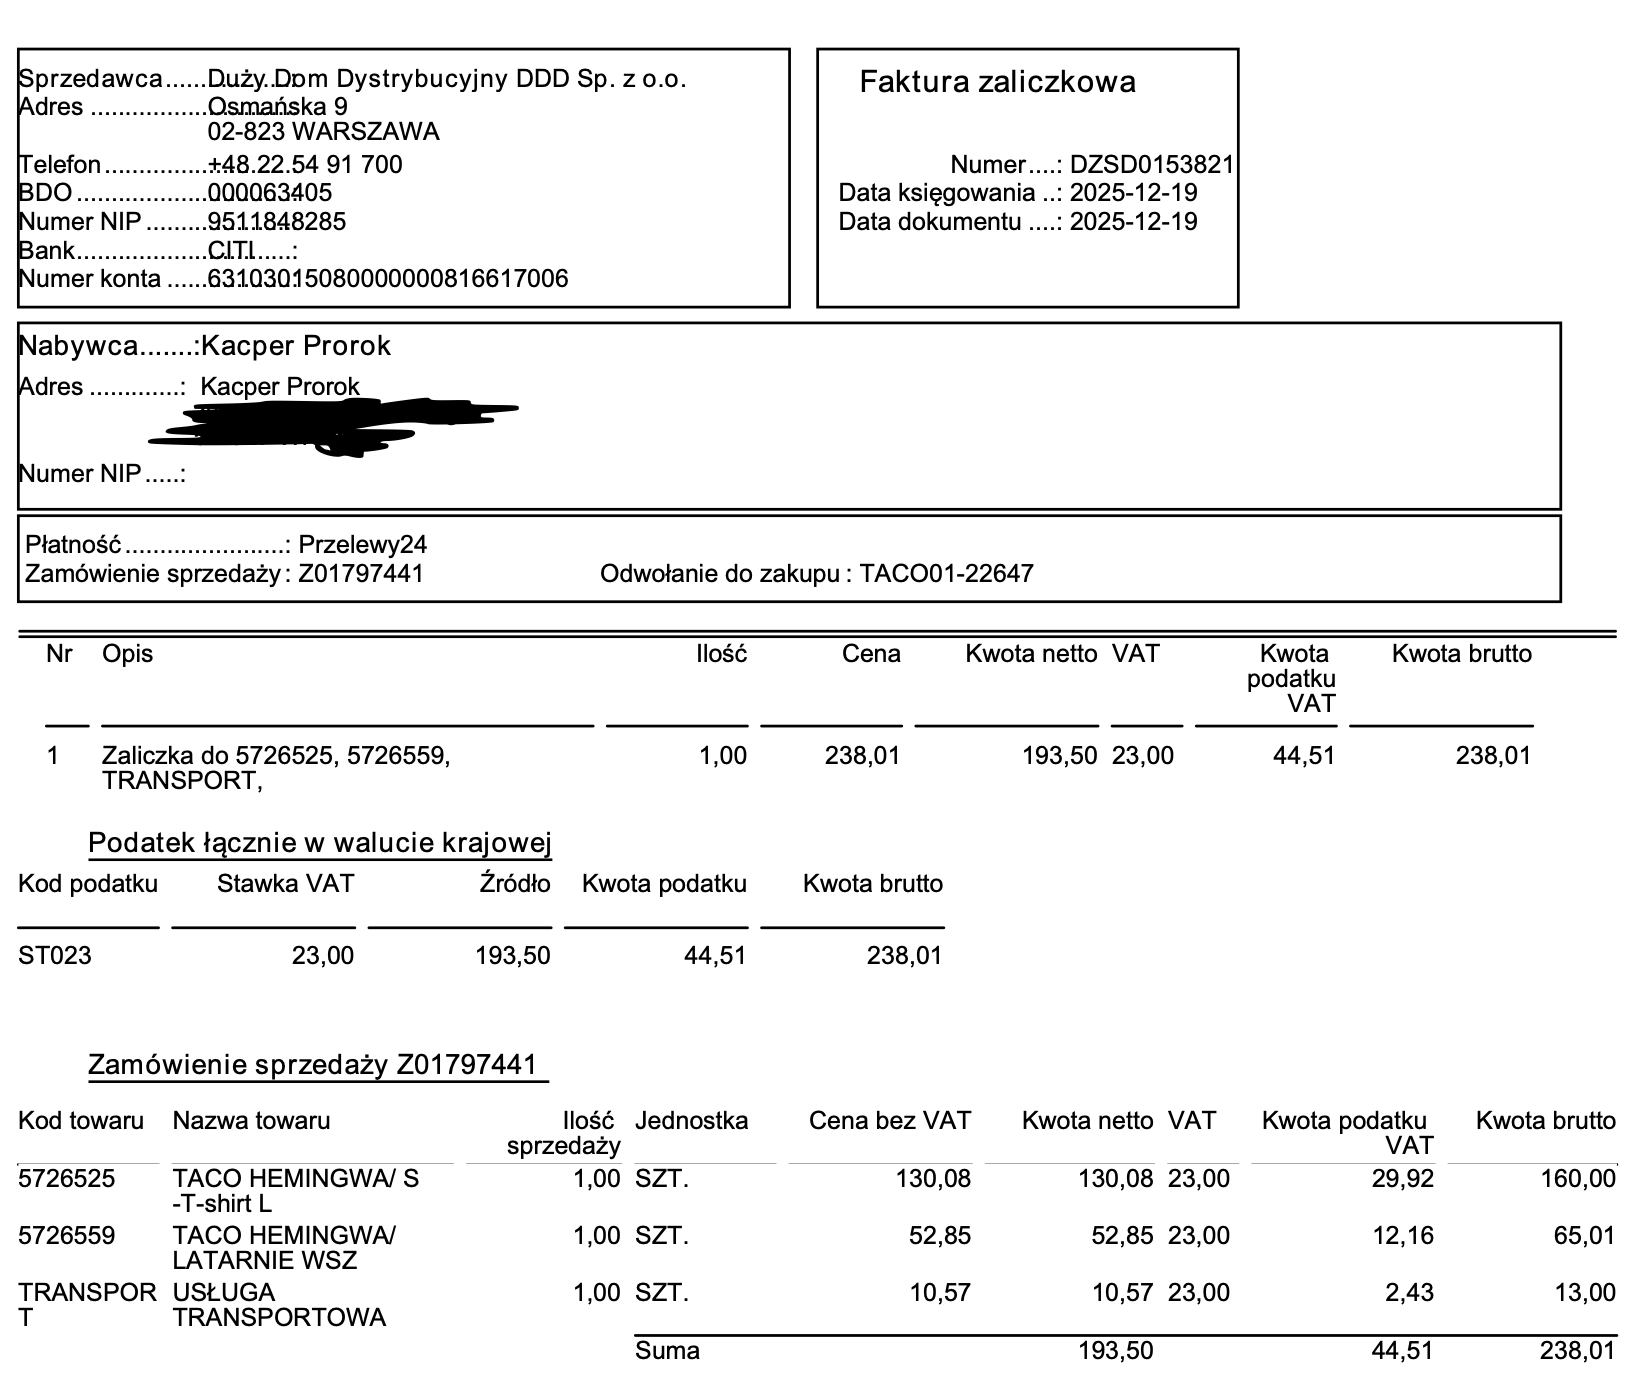

In [23]:
from PIL import Image
from IPython.display import display

# Ścieżka do Twojego pliku PNG
image_path = "data/invoices/DZSD_jpg.png"

try:
    # Otwieramy obraz bezpośrednio
    img = Image.open(image_path)
    
    # Wyświetlamy go w notatniku
    print(f"Otwarto obraz: {image_path}")
    display(img)
    
except Exception as e:
    print(f"Błąd: {e}")

In [24]:
results = []
print("Testowanie Docling...")
start = time.perf_counter()
text_docling = ""
t_docling = None
score_docling = None
docling_dfs = []
tables_all = []
metadata_found = {}

try:
    converter = DocumentConverter()
    res = converter.convert("data/invoices/DZSD_jpg.png")
    try:
        md = res.document.export_to_markdown()
    except Exception:
        md = ""
        for page in res.document.pages:
            txt = page.export_to_markdown()
            if txt:
                md += txt + "\n"
    text_docling = md
    for table in res.document.tables:
        df = table.export_to_dataframe()
        docling_dfs.append(df)
    t_docling = time.perf_counter() - start
    if text_docling:
        metadata_found = extract_metadata_regex(text_docling)
    
except Exception as e:
    print(f"Docling Error: {e}")
    t_docling = time.perf_counter() - start
    

print(f"time:{t_docling}")
print("\n")
for i, df in enumerate(docling_dfs):
    print(f"\n--- Tabela #{i+1} (Docling) ---")
    display(df)

print("\n🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):")
for k, v in metadata_found.items():
    if v:
        print(f"✅ {k}: {v}")
    else:
        print(f"⚠️ {k}: Nie znaleziono (wymagany lepszy Regex)")

Testowanie Docling...


Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


time:7.584397749975324



--- Tabela #1 (Docling) ---


\
0                                   1   
1  Podatek łacznie w walucie krajowej   
2                         Kod podatku   
3                               ST023   

                                    Nr Opis  \
0  Zaliczka do 5726525, 5726559, TRANSPORT,   
1        Podatek łacznie w walucie krajowej   
2                               Kod podatku   
3                                     ST023   

                                                            Ilość  \
0  Zaliczka do 5726525, 5726559, TRANSPORT,                  1,00   
1        Podatek łacznie w walucie krajowej                         
2                                Stawka VAT  Źródło Kwota podatku   
3                                     23,00          193,50 44,51   

           Cena Kwota netto VAT Kwota podatku VAT Kwota brutto  
0        238,01    193,50 23,00             44,51       238,01  
1                                                               
2  Kwota brutto                                                 
3        238,01


--- Tabela #2 (Docling) ---


Kod towaru                  Nazwa towaru llość Jednostka sprzedaży  \
0    5726525   TACO HEMINGWA/ S -T-shirt L                 1,00 SZT.   
1    5726559   TACO HEMINGWA/ LATARNIE WSZ                 1,00 SZT.   
2             TRANSPOR USANSP TRANSPORTOWA                 1,00 SZT.   
3                                                               Suma   

  Cena bez VAT Kwota netto VAT Kwota podatku VAT Kwota brutto  
0       130,08    130,08 23,00             29,92       160,00  
1        52,85     52,85 23,00             12,16        65,01  
2        10,57     10,57 23,00              2,43        13,00  
3                       193,50             44,51       238,01


🔍 Wykryte Metadane (Regex na tekście z PDFPlumber):
✅ Numer faktury: zaliczkowa
✅ Data wystawienia: 2025-12-19
⚠️ Suma (Brutto): Nie znaleziono (wymagany lepszy Regex)


## 3.4 Azure Document Inteligence

### 3.4.1 Faktura prosta

In [25]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="application/pdf"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/invoice-1-3.pdf"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: invoice-1-3.pdf ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: zencorporations
👤 Klient:     La Galerie
🔢 Nr faktury: 1213
📅 Data:       16.12.2021
💰 SUMA:       2809.3 None

📦 POZYCJE NA FAKTURZE (3 tabel):


Product Unit Price [EUR] Total [EUR]
0         Glossostigma\nQty. 3             9.90       29.70
1           Bayberry\nQty. 222             5.44    1,207.68
2           Waxflower\nQty. 34             1.67       56.78
3   Carolina Geranium\nQty. 45             4.17      187.65
4             Smooth Solomon's                             
5                         Seal                             
6                       Qty. 3             4.97       14.91
7  El Yunque Colorado\nQty. 23             9.97      229.31

Queen Anne's Lace              
0                      Qty. 32  6.05  193.60
1  Alaskan Douglasia\nQty. 122  4.36  531.92
2          Deer Sedge\nQty. 23  3.82   87.86
3       Indian Tobacco\nQty. 2  7.25   14.50

Subtotal  2553.91
0  Sales Tax   255.39
1  Total Due  2809.30

### 3.4.2 Faktura cięzka

In [26]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="application/pdf"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/invoice-3-0.pdf"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: invoice-3-0.pdf ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: €
NEID
👤 Klient:     Obacht AG
🔢 Nr faktury: 4235
📅 Data:       October 12, 2021
💰 SUMA:       213470.0 None

📦 POZYCJE NA FAKTURZE (2 tabel):


Make/Model Product Code Unit Price
0  Chrysler/300M\nCountry of origin: France\nColo...  762-88-0358      45400
1  Mercedes-Benz/SL-Class\nCountry of origin: Ita...  630-35-4784      12100
2    Audi/90\nCountry of origin: Spain\nColor: Black  582-33-2563      18100
3  Ford/Bronco\nCountry of origin: Spain\nColor: ...  877-84-8130      30900
4     Audi/A6\nCountry of origin: France\nColor: Red  638-13-7553      30800
5  Mitsubishi/Eclipse\nCountry of origin: Spain\n...  771-81-4708      22900
6  Hummer/H1\nCountry of origin: Germany\nColor: ...  694-41-6257      27500

Subtotal  187700
0                        Sales Tax   18770
1              Shipping & Handling    7000
2  Total Due By: November 12, 2021  213470

### 3.4.3 Faktura cięzka + OCR

Ta sama co Docling

In [27]:
def azure_table_to_dataframe(table_result):
    """Pomocnicza funkcja do konwersji tabeli Azure na DataFrame"""
    row_count = table_result.row_count
    col_count = table_result.column_count
    grid = [["" for _ in range(col_count)] for _ in range(row_count)]
    
    for cell in table_result.cells:
        grid[cell.row_index][cell.column_index] = cell.content
        
    if row_count > 1:
        return pd.DataFrame(grid[1:], columns=grid[0])
    else:
        return pd.DataFrame(grid)

def analyze_invoice(pdf_path):
    print(f"--- 🧾 Analiza Faktury: {os.path.basename(pdf_path)} ---")
    
    try:
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        with open(pdf_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-invoice",  
                body=f,
                content_type="image/png"
            )
        
        result = poller.result()
        if result.documents:
            doc = result.documents[0] 
            fields = doc.fields
            
            print("\n🔍 GŁÓWNE DANE FAKTURY:")
            vendor = fields.get("VendorName")
            customer = fields.get("CustomerName")
            invoice_date = fields.get("InvoiceDate")
            invoice_id = fields.get("InvoiceId")
            total = fields.get("InvoiceTotal")
            
            if vendor: print(f"🏢 Sprzedawca: {vendor.get('content')}")
            if customer: print(f"👤 Klient:     {customer.get('content')}")
            if invoice_id: print(f"🔢 Nr faktury: {invoice_id.get('content')}")
            if invoice_date: print(f"📅 Data:       {invoice_date.get('content')}")
            
            if total:
                val = total.get('valueCurrency')
                amount = val.get('amount') if val else total.get('content')
                currency = val.get('currencySymbol') if val else ""
                print(f"💰 SUMA:       {amount} {currency}")

        if result.tables:
            print(f"\n📦 POZYCJE NA FAKTURZE ({len(result.tables)} tabel):")
            for i, table in enumerate(result.tables):
                df = azure_table_to_dataframe(table)
                try:
                    display(df)
                except NameError:
                    print(df)
        else:
            print("ℹ️ Nie wykryto tabeli z produktami.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

plik_testowy = "data/invoices/DZSD_jpg.png"

if os.path.exists(plik_testowy):
    analyze_invoice(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 🧾 Analiza Faktury: DZSD_jpg.png ---

🔍 GŁÓWNE DANE FAKTURY:
🏢 Sprzedawca: Duży .. Dom Dystrybucyjny DDD Sp. z o.o.
👤 Klient:     :Kacper Prorok
🔢 Nr faktury: DZSD0153821
📅 Data:       2025-12-19
2025-12-19
💰 SUMA:       238.01 None

📦 POZYCJE NA FAKTURZE (4 tabel):


Sprzedawca Duży .. Dom Dystrybucyjny DDD Sp. z o.o.
0        Adres                               Osmańska 9
1                                       02-823 WARSZAWA
2      Telefon                         +48.22.54 91 700
3          BDO                                000063405
4    Numer NIP                               9511848285
5         Bank                           C.I.T.L .....:
6  Numer konta               63103015080000000816617006

Nr                                       Opis Ilość    Cena Kwota netto  \
0  1  Zaliczka do 5726525, 5726559,\nTRANSPORT,  1,00  238,01      193,50   

     VAT Kwota\npodatku\nVAT Kwota brutto  
0  23,00               44,51       238,01

Kod podatku Stawka VAT  Źródło Kwota podatku Kwota brutto
0       ST023      23,00  193,50         44,51       238,01

Kod towaru                  Nazwa towaru Ilość\nsprzedaży Jednostka  \
0      5726525  TACO HEMINGWA/ S\n-T-shirt L             1,00      SZT.   
1      5726559  TACO HEMINGWA/\nLATARNIE WSZ             1,00      SZT.   
2  TRANSPOR\nT          USŁUGA\nTRANSPORTOWA             1,00      SZT.   

  Cena bez VAT Kwota netto    VAT Kwota podatku\nVAT Kwota brutto  
0       130,08      130,08  23,00              29,92       160,00  
1        52,85       52,85  23,00              12,16        65,01  
2        10,57       10,57  23,00               2,43        13,00

# Rozdział 4: OCR i skany

Z racji, ze funkcja OCR występuje tylko w przypadku bibliotek test w tym miejscu mozna by przeprowadzic tylko dla Docling i Azure Document Inteligence. Lecz postaram się tutaj jeszcze pokazać jedną bibliotekę, która słuzy stricte do tylko nakladania OCR na pdf - Tesseract. Z jej pomoca mozemy najpierw nalozyc tekst na pdf/jpg a potem uzyc bibliotek do wyciagania tekstu - PyMuPDF i PDFplumber

Otwarto obraz: data/images/Screenshot 2026-02-01 at 09.58.02.png


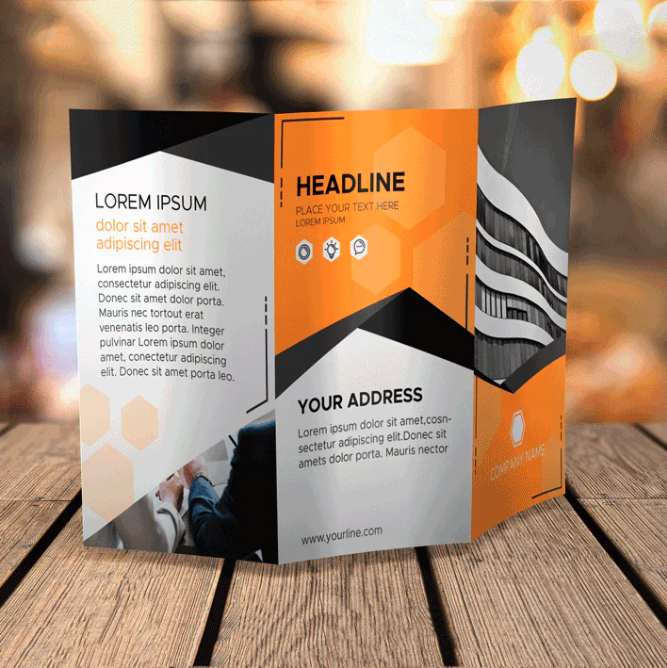

In [40]:
from PIL import Image
from IPython.display import display

# Ścieżka do Twojego pliku PNG
image_path = "data/images/Screenshot 2026-02-01 at 09.58.02.png"

try:
    # Otwieramy obraz bezpośrednio
    img = Image.open(image_path)
    
    
    # Wyświetlamy go w notatniku
    print(f"Otwarto obraz: {image_path}")
    display(img)
    
except Exception as e:
    print(f"Błąd: {e}")

## 4.1 Tesseract + PyMuPDF

### 4.1.2 Ulotka 1

In [36]:
import pytesseract
image = Image.open("data/images/Screenshot 2026-02-01 at 09.58.02.png")

width, height = img.size
new_size = (width * 3, height * 3)
img_resized = img.resize(new_size, Image.Resampling.LANCZOS) ## powiekszenie obrazu co ulatwi prace

pdf_bytes = pytesseract.image_to_pdf_or_hocr(img_resized, extension='pdf', lang='eng')

with open("data/images/ulotkaPDF.pdf", "wb") as f:
            f.write(pdf_bytes)

results = []
print("Testowanie PyMuPDF (Best Effort)...")
start = time.perf_counter()

try:
    doc = fitz.open("data/images/ulotkaPDF.pdf")
    text_parts = []
    
    for page in doc:
        blocks = page.get_text("blocks", sort=True)
        
        page_height = page.rect.height
        
        for b in blocks:
            x0, y0, x1, y1, text, block_no, block_type = b

            if block_type != 0:
                continue
                
            if y0 < page_height * 0.05 or y1 > page_height * 0.95:
                continue
            
            if len(text.strip()) < 3 and text.strip().isdigit():
                continue
                
            text_parts.append(text)

    raw_text = "\n".join(text_parts)
    
    text_pymu_cleaned = clean_pymupdf_text(raw_text)
    
    t_pymu = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_3.split())
    score_pymu = fuzz.ratio(text_pymu_cleaned, ground_truth_cleaned)

except Exception as e:
    print(f"PyMuPDF Error: {e}")
    text_pymu_cleaned = ""
    t_pymu = 0
    score_pymu = 0

print(f"Time: {t_pymu:.4f} s")
print(f"Accuracy Score: {score_pymu:.2f}%")

print("-" * 30)
print("PREVIEW (First 500 chars):")
print(text_pymu_cleaned[:1500] + "...") 
print("-" * 30)



Testowanie PyMuPDF (Best Effort)...
Time: 0.0041 s
Accuracy Score: 74.35%
------------------------------
PREVIEW (First 500 chars):
LOREM IPSUM rem ipsum dolor sit amet, nsectetur adipiscing elit Donec sit amet dolor porta Mauris nec tortout erat venenatis leo porta Integer pulvinar Lorem ipsum dolor amet, conectetur edipiscing elit. Donec sit amet porta leo. sum doror sit onan ih dipiscing elit. Donec St wi ne _ Mauris nector ; ‘* f amets porta...
------------------------------


## 4.2 Pytesreact + PDFplumber

### 4.2.1 Ulotka prosta

In [37]:
import pdfplumber
import time

# Zakładam, że zmienne clean_pymupdf_text i ground_truth_simple_2 są zdefiniowane wcześniej

results = []
print("Testowanie pdfplumber (Simple)...")
start = time.perf_counter()

try:
    text_parts = []
    
    # 1. Otwarcie pliku
    with pdfplumber.open("data/images/ulotkaPDF.pdf") as pdf:
        for page in pdf.pages:
            # 2. Wyciągnięcie tekstu jedną komendą
            # pdfplumber sam dba o spacje i układ
            text = page.extract_text()
            
            if text:
                text_parts.append(text)

    # Łączenie stron
    raw_text = "\n".join(text_parts)
    
    # Czyszczenie i liczenie wyniku (tak samo jak wcześniej)
    text_plumber_cleaned = clean_pymupdf_text(raw_text)
    t_plumber = time.perf_counter() - start
    
    ground_truth_cleaned = " ".join(ground_truth_simple_2.split())
    score_plumber = fuzz.ratio(text_plumber_cleaned, ground_truth_simple_3)

except Exception as e:
    print(f"pdfplumber Error: {e}")
    text_plumber_cleaned = ""
    t_plumber = 0
    score_plumber = 0

print(f"Time: {t_plumber:.4f} s")
print(f"Accuracy Score: {score_plumber:.2f}%")

print("-" * 30)
print("PREVIEW:")
print(text_plumber_cleaned[:500] + "...") 
print("-" * 30)

Testowanie pdfplumber (Simple)...
Time: 0.1030 s
Accuracy Score: 72.59%
------------------------------
PREVIEW:
LOREM IPSUM rem ipsum dolor sit amet, nsectetur adipiscing elit Donec sit amet dolor porta Mauris nec tortout erat venenatis leo porta Integer pulvinar Lorem ipsum dolor amet, conectetur edipiscing elit. Donec sit amet porta leo. sum doror sit onan h dipiscing elit. Donec St i ; _ Mauris nector wi ne porta amets ‘* f...
------------------------------


## 4.3 Docling

### 4.3.1 Ulotka prosta

In [39]:
from docling.document_converter import DocumentConverter

# Ścieżka do pliku
plik = "data/images/Screenshot 2026-02-01 at 09.58.02.png"

print(f"--- 🚀 Docling: {plik} ---")

try:
    # 1. Inicjalizacja i konwersja
    converter = DocumentConverter()
    result = converter.convert(plik)

    # 2. Wyświetlenie całej zawartości
    # Docling najlepiej zwraca treść jako Markdown (zachowuje strukturę nagłówków i tabel)
    text = result.document.export_to_markdown()
    score_docling = fuzz.ratio(text, ground_truth_simple_3)
    print(text)
    print(score_docling)

except Exception as e:
    print(f"❌ Błąd Docling: {e}")

--- 🚀 Docling: data/images/Screenshot 2026-02-01 at 09.58.02.png ---
## LOREM IPSUM

## dolor sit amet adipiscing elit

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec sit amet dolor porta. Mauris nec tortout erat venenatis leo porta. Integer pulvinar Lorem ipsum dolor amet, conectetur adipiscing elit. Donec sit amet porta leo.

## HEADLINE

PLACE YOUR TEXT HERE LOREM IPSUM

<!-- image -->

<!-- image -->

<!-- image -->

## YOUR ADDRESS

Lorem ipsum dolor sit amet, cosnsectetur adipiscing elit.Donec sit amets dolor porta. Mauris nector www.yourline.com
89.00414937759335


## 4.4 Azure Document Inteligence

### 4.4.1 Ulotka 1

In [ ]:
import os
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.core.credentials import AzureKeyCredential

# ==========================================
# 🔑 KONFIGURACJA
# ==========================================
AZURE_ENDPOINT 
AZURE_KEY 
extracted_text_parts=[]

def simple_ocr_azure(image_path):
    print(f"--- 📄 Odczyt tekstu (Azure): {os.path.basename(image_path)} ---")
    
    try:
        # 1. Klient
        client = DocumentIntelligenceClient(
            endpoint=AZURE_ENDPOINT, 
            credential=AzureKeyCredential(AZURE_KEY)
        )

        # 2. Wysyłamy plik - używamy modelu "prebuilt-read" (najlepszy do samego tekstu)
        with open(image_path, "rb") as f:
            poller = client.begin_analyze_document(
                "prebuilt-read",  # 👈 ZMIANA: Model do czytania, a nie do faktur
                body=f,
                content_type="image/png"
            )
        
        # 3. Czekamy na wynik
        result = poller.result()
        
        # 4. Wyświetlamy tekst linia po linii
        # Azure dzieli wynik na strony -> linie -> słowa
        if result.pages:
            print("\n📝 ZNALEZIONA TREŚĆ:")
            print("=" * 30)
            
            for page in result.pages:
                for line in page.lines:
                    print(line.content)
                    
            print("=" * 30)

        else:
            print("ℹ️ Nie znaleziono tekstu.")

    except Exception as e:
        print(f"❌ Błąd Azure: {e}")

# ==========================================
# 🚀 TESTOWANIE
# ==========================================
plik_testowy = "data/images/Screenshot 2026-02-01 at 09.58.02.png"

if os.path.exists(plik_testowy):
    simple_ocr_azure(plik_testowy)
else:
    print(f"⚠️ Nie znaleziono pliku: {plik_testowy}")

--- 📄 Odczyt tekstu (Azure): Screenshot 2026-02-01 at 09.58.02.png ---

📝 ZNALEZIONA TREŚĆ:
LOREM IPSUM
dolor sit amet
adipiscing elit
Lorem ipsum dolor sit amet,
consectetur adipiscing elit.
Donec sit amet dolor porta.
Mauris nec tortout erat
venenatis leo porta. Integer
pulvinar Lorem ipsum dolor
amet, conectetur adipiscing
elit. Donec sit amet porta leo.
--
HEADLINE
PLACE YOUR TEXT HERE
LOREM IPSUM
0
YOUR ADDRESS
Lorem ipsum dolor sit amet,cosn-
sectetur adipiscing elit.Donec sit
amets dolor porta. Mauris nector
www.yourline.com
COMPANY NAME
0.0
